In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

## Cross-correlation

In [ ]:
res = read_results(
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_186/test_', n_params=30
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_20/test_', n_params=20
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_187/test_', n_params=33
    prefix='./retrieval_outputs/DENIS_J0255_nominal_5/test_', n_params=32
    )
posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res

In [ ]:
import copy

plt.figure(figsize=(15,5))
pRT_atm_1 = af.pickle_load(
    './retrieval_outputs/DENIS_J0255_nominal_5/test_data/pRT_atm_broad.pkl'
    )
params_1_copy = bestfit_params_1['params'].copy()

m_spec_1 = pRT_atm_1(
        mass_fractions=Chem_1.mass_fractions, 
        temperature=PT_1.temperature, 
        params=params_1_copy, 
        get_full_spectrum=True
        )
for i in range(d_spec_1.n_orders):
    plt.plot(pRT_atm_1.wave_pRT_grid[i], pRT_atm_1.flux_pRT_grid[i]/np.median(pRT_atm_1.flux_pRT_grid[3][5000:5500]), c='k')

params_1_copy['log_g'] = 5.0

m_spec_1 = pRT_atm_1(
        mass_fractions=Chem_1.mass_fractions, 
        temperature=PT_1.temperature, 
        params=params_1_copy, 
        get_full_spectrum=True
        )
for i in range(d_spec_1.n_orders):
    plt.plot(pRT_atm_1.wave_pRT_grid[i], pRT_atm_1.flux_pRT_grid[i]/np.median(pRT_atm_1.flux_pRT_grid[3][5000:5500]), c='C0', lw=1)
    #print(len(pRT_atm_1.flux_pRT_grid[3][5000]))

plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d

from tqdm import tqdm
from retrieval_base.spectrum import ModelSpectrum

import copy

pRT_atm_1 = af.pickle_load(
    './retrieval_outputs/DENIS_J0255_nominal_5/test_data/pRT_atm_broad.pkl'
    )

params_1_copy = bestfit_params_1['params'].copy()

mask = d_spec_1.mask_isfinite

def species_CCF(
        line_species, 
        rv=np.arange(-1000, 1000+1e-6, 5)
        ):
    
    
    CCF = np.ones((d_spec_1.n_orders, d_spec_1.n_dets, len(rv))) * np.nan
    ACF = np.copy(CCF)


    pRT_atm_1_wo_species = copy.deepcopy(pRT_atm_1)
    Chem_1_wo_species = copy.deepcopy(Chem_1)

    Chem_1_wo_species.mass_fractions[line_species] = \
        0 * Chem_1_wo_species.mass_fractions[line_species]

    m_spec_1 = pRT_atm_1(
        mass_fractions=Chem_1.mass_fractions, 
        temperature=PT_1.temperature, 
        params=params_1_copy, 
        get_full_spectrum=True
        )
    m_spec_1_wo_species = pRT_atm_1_wo_species(
        mass_fractions=Chem_1_wo_species.mass_fractions, 
        temperature=PT_1.temperature, 
        params=params_1_copy, 
        get_full_spectrum=True
        )

    # Get the (static) residuals wrt 13CO-less spectrum
    d_residuals_wo_species = d_spec_1.flux - LogLike_1.f[:,:,None]*m_spec_1_wo_species.flux
    m_residuals_static  = LogLike_1.f[:,:,None] * (m_spec_1.flux - m_spec_1_wo_species.flux)

    #'''
    # Apply high-pass filter to the residuals
    lp_d_res = np.nan*np.ones_like(d_residuals_wo_species)
    lp_d_res[mask] = gaussian_filter1d(
        d_residuals_wo_species[mask], sigma=300, axis=-1, mode='reflect'
        )
    d_residuals_wo_species -= lp_d_res

    # Apply high-pass filter to the residuals
    lp_m_res = np.nan*np.ones_like(m_residuals_static)
    lp_m_res[mask] = gaussian_filter1d(
        m_residuals_static[mask], sigma=300, axis=-1, mode='reflect'
        )
    m_residuals_static -= lp_m_res
    #'''

    for h, rv_h in enumerate(tqdm(rv)):

        # Store copies of the rv-shifted spectrum
        m_flux_1_shifted            = np.ones_like(d_spec_1.flux) * np.nan
        m_flux_1_wo_species_shifted = np.ones_like(d_spec_1.flux) * np.nan

        for i in range(d_spec_1.n_orders):
            
            # Per order
            wave_i = pRT_atm_1.wave_pRT_grid[i]
            flux_i = pRT_atm_1.flux_pRT_grid[i].copy()

            # Create a ModelSpectrum instance
            m_spec_i = ModelSpectrum(
                wave=wave_i, flux=flux_i, 
                lbl_opacity_sampling=pRT_atm_1.lbl_opacity_sampling
                )

            # Apply radial velocity-shift
            m_spec_i.rv_shift(rv_h, replace_wave=True)

            # Rebin onto the data's wavelength grid
            m_spec_i.rebin(d_wave=d_spec_1.wave[i,:], replace_wave_flux=True)

            # Store flux
            m_flux_1_shifted[i,:,:] = m_spec_i.flux.copy()


            # Same for model w/o 13CO ----------------
            # Per order
            wave_i = pRT_atm_1_wo_species.wave_pRT_grid[i]
            flux_i = pRT_atm_1_wo_species.flux_pRT_grid[i].copy()

            # Create a ModelSpectrum instance
            m_spec_i = ModelSpectrum(
                wave=wave_i, flux=flux_i, 
                lbl_opacity_sampling=pRT_atm_1_wo_species.lbl_opacity_sampling
                )

            # Apply radial velocity-shift
            m_spec_i.rv_shift(rv_h, replace_wave=True)

            # Rebin onto the data's wavelength grid
            m_spec_i.rebin(d_wave=d_spec_1.wave[i,:], replace_wave_flux=True)

            # Store flux
            m_flux_1_wo_species_shifted[i,:,:] = m_spec_i.flux.copy()

        
        # Get 13CO residuals
        m_residuals = LogLike_1.f[:,:,None] * (m_flux_1_shifted - m_flux_1_wo_species_shifted)

        #'''
        # Apply high-pass filter to the residuals
        lp_m_res = np.nan*np.ones_like(m_residuals)
        lp_m_res[mask] = gaussian_filter1d(
            m_residuals[mask], sigma=300, axis=-1, mode='reflect'
            )
        m_residuals -= lp_m_res
        #'''

        for i in range(d_spec_1.n_orders):
            for j in range(d_spec_1.n_dets):

                # Calculate cross-correlation coefficient
                # (weighted by the covariance matrix)
                
                # R_m^T cov^-1 R_d
                CCF[i,j,h] = np.dot(
                    m_residuals[i,j,mask[i,j]], 
                    1/LogLike_1.beta[i,j]**2 * \
                        Cov_1[i,j].solve(d_residuals_wo_species[i,j,mask[i,j]])
                    )
                
                # R_m^T cov^-1 R_m
                ACF[i,j,h] = np.dot(
                    m_residuals[i,j,mask[i,j]], 
                    1/LogLike_1.beta[i,j]**2 * \
                        Cov_1[i,j].solve(m_residuals_static[i,j,mask[i,j]])
                    )

    return rv, CCF, ACF

def convert_CCF_to_SNR(rv, CCF, ACF, rv_to_exclude=(-200,200)):

    # Select samples from outside the expected peak
    rv_mask = (rv < rv_to_exclude[0]) | (rv > rv_to_exclude[1])

    mean_CCF = np.nanmean(CCF[rv_mask])
    std_CCF  = np.nanstd(((CCF-mean_CCF) - (ACF-mean_CCF))[rv_mask])

    # Correct the offset and compute the signal-to-noise
    CCF_SNR = (CCF - mean_CCF) / std_CCF
    ACF_SNR = (ACF - mean_CCF) / std_CCF

    tuple_to_return = (CCF_SNR, ACF_SNR, mean_CCF, std_CCF, rv_mask)
    return tuple_to_return

In [ ]:
rv, CCF_CH4, ACF_CH4 = species_CCF(
        line_species='CH4_hargreaves_main_iso', 
        rv=np.arange(-1000, 1000+1e-6, 1)
        )

CCF_SNR_CH4, ACF_SNR_CH4, mean_CCF_CH4, std_CCF_CH4, rv_mask = convert_CCF_to_SNR(
    rv, CCF_CH4.sum(axis=(0,1)), ACF_CH4.sum(axis=(0,1)), rv_to_exclude=(-200,200)
    )

In [ ]:
rv, CCF_NH3, ACF_NH3 = species_CCF(
        line_species='NH3_coles_main_iso', 
        rv=np.arange(-1000, 1000+1e-6, 1)
        )

CCF_SNR_NH3, ACF_SNR_NH3, mean_CCF_NH3, std_CCF_NH3, rv_mask = convert_CCF_to_SNR(
    rv, CCF_NH3.sum(axis=(0,1)), ACF_NH3.sum(axis=(0,1)), rv_to_exclude=(-200,200)
    )

In [ ]:
print(rv[np.argmax(CCF_NH3.sum(axis=(0,1)))], rv[np.argmax(ACF_NH3.sum(axis=(0,1)))])

plt.plot(rv, ACF_NH3.sum(axis=(0,1)))
plt.plot(rv, CCF_NH3.sum(axis=(0,1)))
plt.axvline(rv[np.argmax(CCF_NH3.sum(axis=(0,1)))])
plt.xlim(-100,100)
plt.show()

In [ ]:
rv, CCF_13CO, ACF_13CO = species_CCF(
        line_species='CO_36', 
        rv=np.arange(-1000, 1000+1e-6, 1)
        )

CCF_SNR_13CO, ACF_SNR_13CO, mean_CCF_13CO, std_CCF_13CO, rv_mask = convert_CCF_to_SNR(
    rv, CCF_13CO.sum(axis=(0,1)), ACF_13CO.sum(axis=(0,1)), rv_to_exclude=(-200,200)
    )

In [ ]:
fig = plt.figure(figsize=(5,7))
gs = fig.add_gridspec(
    nrows=8, ncols=1, left=0.15, right=0.89, top=0.98, bottom=0.08, 
    height_ratios=[1,0.2,0.15, 1,0.2,0.15, 1,0.2], hspace=0, 
    )

ax = np.array([
    [fig.add_subplot(gs[i,j]) for j in range(1)] for i in [0,1,3,4,6,7]
    ])

ax_SNR = np.array([
    [ax[i,j].twinx() for i in range(ax.shape[0])] for j in range(ax.shape[1])
    ]).T

for ax_i in ax.flatten():
    ax_i.axvspan(-200, 200, fc='k', alpha=0.06, ec='none')
    ax_i.axhline(0, c='k', lw=0.5, alpha=0.5)
    ax_i.axvline(0, c='k', lw=0.5, alpha=0.5)

    ax_i.set(xlim=(rv.min(), rv.max()))

for ax_i in ax[0::2].flatten():
    #ax_i.set_facecolor('k')
    ax_i.set(xticks=[])

for ax_i in ax[[1,3]].flatten():
    #ax_i.set_facecolor('k')
    ax_i.set(xticklabels=[])

# -------------------------------------------
ax[0,0].plot(rv, CCF_CH4.sum(axis=(0,1))-mean_CCF_CH4, c='C4', label='CCF')
ax[0,0].plot(rv, ACF_CH4.sum(axis=(0,1))-mean_CCF_CH4, c='C4', ls='--', alpha=0.4, label='ACF')

ax[1,0].plot(
    rv, (CCF_CH4.sum(axis=(0,1))-mean_CCF_CH4) - (ACF_CH4.sum(axis=(0,1))-mean_CCF_CH4), 
    c='C4', ls='-', 
    )

'''
ax_SNR[0,0].plot(rv, CCF_SNR_CH4, c='k')
ax_SNR[1,0].plot(
    rv, ((CCF_CH4.sum(axis=(0,1))-mean_CCF_CH4) - (ACF_CH4.sum(axis=(0,1))-mean_CCF_CH4))/std_CCF_CH4, 
    c='k', ls='--', #alpha=0.4
    )
'''

# -------------------------------------------
ax[2,0].plot(rv, CCF_NH3.sum(axis=(0,1))-mean_CCF_NH3, c='C8')
ax[2,0].plot(rv, ACF_NH3.sum(axis=(0,1))-mean_CCF_NH3, c='C8', ls='--', alpha=0.4)

ax[3,0].plot(
    rv, (CCF_NH3.sum(axis=(0,1))-mean_CCF_NH3) - (ACF_NH3.sum(axis=(0,1))-mean_CCF_NH3), 
    c='C8', ls='-', 
    )

# -------------------------------------------
ax[4,0].plot(rv, CCF_13CO.sum(axis=(0,1))-mean_CCF_13CO, c='C5')
ax[4,0].plot(rv, ACF_13CO.sum(axis=(0,1))-mean_CCF_13CO, c='C5', ls='--', alpha=0.4)

ax[5,0].plot(
    rv, (CCF_13CO.sum(axis=(0,1))-mean_CCF_13CO) - (ACF_13CO.sum(axis=(0,1))-mean_CCF_13CO), 
    c='C5', ls='-', 
    )

ax_SNR[0,0].set(ylim=(-9,35))
ax_SNR[1,0].set(ylim=(-5,5))

ax_SNR[2,0].set(ylim=(-4,13))
ax_SNR[3,0].set(ylim=(-5,5))

ax_SNR[4,0].set(ylim=(-3.5,6))
ax_SNR[5,0].set(ylim=(-5,5))

for i in [0,1]:
    ylim = np.array(list(ax_SNR[i,0].get_ylim()))
    ax[i,0].set(ylim=ylim*std_CCF_CH4)
for i in [2,3]:
    ylim = np.array(list(ax_SNR[i,0].get_ylim()))
    ax[i,0].set(ylim=ylim*std_CCF_NH3)
for i in [4,5]:
    ylim = np.array(list(ax_SNR[i,0].get_ylim()))
    ax[i,0].set(ylim=ylim*std_CCF_13CO)


SNR_rv0 = CCF_SNR_CH4[rv==0][0]
ax_SNR[0,0].annotate(
    '{:.1f}'.format(SNR_rv0) + r'$\sigma$', xy=(0,SNR_rv0), 
    xytext=(0.6,0.92), textcoords=ax[0,0].transAxes, 
    ha='left', va='top', color='C4', fontsize=15, 
    arrowprops={
        'arrowstyle':'-', 'lw':1, 'color':'C4', 'alpha':0.4, 
        'connectionstyle':'angle3,angleA=180,angleB=-60', 'shrinkA':2, 'shrinkB':7
        }
    )
SNR_rv0 = CCF_SNR_NH3[rv==0][0]
ax_SNR[2,0].annotate(
    '{:.1f}'.format(SNR_rv0) + r'$\sigma$', xy=(0,SNR_rv0), 
    xytext=(0.6,0.92), textcoords=ax[2,0].transAxes, 
    ha='left', va='top', color='C8', fontsize=15, 
    arrowprops={
        'arrowstyle':'-', 'lw':1, 'color':'C8', 'alpha':0.4, 
        'connectionstyle':'angle3,angleA=180,angleB=-60', 'shrinkA':2, 'shrinkB':7
        }
    )

SNR_rv0 = CCF_SNR_13CO[rv==0][0]
ax_SNR[4,0].annotate(
    '{:.1f}'.format(SNR_rv0) + r'$\sigma$', xy=(0,SNR_rv0), 
    xytext=(0.6,0.92), textcoords=ax[4,0].transAxes, 
    ha='left', va='top', color='C5', fontsize=15, 
    arrowprops={
        'arrowstyle':'-', 'lw':1, 'color':'C5', 'alpha':0.4, 
        'connectionstyle':'angle3,angleA=180,angleB=-60', 'shrinkA':2, 'shrinkB':7
        }
    )


ax[0,0].annotate(
    r'CH$_4$', xy=(0.03,0.92), xycoords=ax[0,0].transAxes, 
    ha='left', va='top', fontsize=15, color='C4'
)
ax[2,0].annotate(
    r'NH$_3$', xy=(0.03,0.92), xycoords=ax[2,0].transAxes, 
    ha='left', va='top', fontsize=15, color='C8'
)
ax[4,0].annotate(
    r'$^{13}$CO', xy=(0.03,0.92), xycoords=ax[4,0].transAxes, 
    ha='left', va='top', fontsize=15, color='C5'
)


ax[0,0].legend(
    loc='upper left', bbox_to_anchor=[0,0.72], frameon=False, 
    handlelength=1.2, handletextpad=0.5, labelspacing=0.3, 
    )

ax[0,0].set(ylabel='CCF')
ax[1,0].set_ylabel(r'CCF$-$ACF', labelpad=1.2)

ax[-1,0].set(
    xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
    xticklabels=[r'$-1000$', '', r'$-500$', '', 0, '', r'$500$', '', r'$1000$']
    )

ax_SNR[0,0].set(ylabel=r'S/N')
ax_SNR[1,0].set(ylabel=r'$\sigma$')

plt.savefig('./plots/CCF.pdf')
plt.show()
plt.close()

## LOO analysis

In [ ]:
from PSIS.py.psis import psisloo

#prefix = '/media/sam/PortableSSD/DENIS_J0255_retrieval_outputs'
prefix = '/home/sam/Documents/PhD/CRIRES_data_reduction/retrieval_base/DENIS_J0255/retrieval_outputs'

In [ ]:
ln_Ls_ref = np.load(f'{prefix}/DENIS_J0255_nominal_5/test_data/ln_L_per_pixel_posterior.npy')
#ln_Ls_ref = np.load('/home/sam/Downloads/ln_L_per_pixel_posterior.npy')
#ln_Ls_ref = np.load('/home/sam/Downloads/ln_L_per_pixel_posterior_nominal_5.npy')
#ln_Ls_ref = ln_Ls_ref.reshape((ln_Ls_ref.shape[0], 2048*7*3))

#ln_Ls_ref = np.load('/media/sam/PortableSSD/DENIS_J0255_retrieval_outputs/DENIS_J0255_nominal_5/test_data/ln_L_per_pixel_posterior.npy')
print(np.nanmean(ln_Ls_ref))

d_flux_ref = np.load(f'{prefix}/DENIS_J0255_nominal_5/test_data/d_spec_flux.npy')

elpd_ref = np.ones_like(d_flux_ref) * np.nan
pareto_k_ref = np.ones_like(d_flux_ref) * np.nan

#for i in range(elpd_ref.shape[0]):
#    for j in range(elpd_ref.shape[1]):
#        elpd_tot_ref, elpd_ref[i,j], pareto_k_ref[i,j] = psisloo(log_lik=ln_Ls_ref[:,i,j,:], Reff=1)

elpd_tot_ref, elpd_ref, pareto_k_ref = psisloo(
    log_lik=ln_Ls_ref.reshape((ln_Ls_ref.shape[0], 2048*7*3)), Reff=1
    )
elpd_ref = elpd_ref.reshape((7,3,2048))
pareto_k_ref = pareto_k_ref.reshape((7,3,2048))

elpd_ref[np.isnan(d_flux_ref)] = np.nan
pareto_k_ref[np.isnan(d_flux_ref)] = np.nan
del ln_Ls_ref, d_flux_ref

In [ ]:
ln_Ls_wo_13CO = np.load(f'{prefix}/DENIS_J0255_wo_13CO/test_data/ln_L_per_pixel_posterior.npy')
#ln_Ls_wo_13CO = np.load('/home/sam/Downloads/ln_L_per_pixel_posterior_wo_13CO.npy')
#ln_Ls_wo_13CO = ln_Ls_wo_13CO.reshape((ln_Ls_wo_13CO.shape[0], 2048*7*3))
print(np.nanmean(ln_Ls_wo_13CO))

d_flux_wo_13CO = np.load(f'{prefix}/DENIS_J0255_wo_13CO/test_data/d_spec_flux.npy')

elpd_wo_13CO = np.ones_like(d_flux_wo_13CO) * np.nan
pareto_k_wo_13CO = np.ones_like(d_flux_wo_13CO) * np.nan

#for i in range(elpd_wo_13CO.shape[0]):
#    for j in range(elpd_wo_13CO.shape[1]):
#        elpd_tot_wo_13CO, elpd_wo_13CO[i,j], pareto_k_wo_13CO[i,j] = psisloo(log_lik=ln_Ls_wo_13CO[:,i,j,:], Reff=1)

elpd_tot_wo_13CO, elpd_wo_13CO, pareto_k_wo_13CO = psisloo(
    log_lik=ln_Ls_wo_13CO.reshape((ln_Ls_wo_13CO.shape[0], 2048*7*3)), Reff=1
    )
elpd_wo_13CO = elpd_wo_13CO.reshape((7,3,2048))
pareto_k_wo_13CO = pareto_k_wo_13CO.reshape((7,3,2048))

elpd_wo_13CO[np.isnan(d_flux_wo_13CO)] = np.nan
pareto_k_wo_13CO[np.isnan(d_flux_wo_13CO)] = np.nan
del ln_Ls_wo_13CO, d_flux_wo_13CO

In [ ]:
ln_Ls_wo_NH3 = np.load(f'{prefix}/DENIS_J0255_wo_NH3/test_data/ln_L_per_pixel_posterior.npy')
#ln_Ls_wo_NH3 = np.load('/home/sam/Downloads/ln_L_per_pixel_posterior_wo_NH3.npy')
#ln_Ls_wo_NH3 = ln_Ls_wo_NH3.reshape((ln_Ls_wo_NH3.shape[0], 2048*7*3))
print(np.nanmean(ln_Ls_wo_NH3))

d_flux_wo_NH3 = np.load(f'{prefix}/DENIS_J0255_wo_NH3/test_data/d_spec_flux.npy')

elpd_wo_NH3 = np.ones_like(d_flux_wo_NH3) * np.nan
pareto_k_wo_NH3 = np.ones_like(d_flux_wo_NH3) * np.nan

#for i in range(elpd_wo_NH3.shape[0]):
#    for j in range(elpd_wo_NH3.shape[1]):
#        elpd_tot_wo_NH3, elpd_wo_NH3[i,j], pareto_k_wo_NH3[i,j] = psisloo(log_lik=ln_Ls_wo_NH3[:,i,j,:], Reff=1)

elpd_tot_wo_NH3, elpd_wo_NH3, pareto_k_wo_NH3 = psisloo(
    log_lik=ln_Ls_wo_NH3.reshape((ln_Ls_wo_NH3.shape[0], 2048*7*3)), Reff=1
    )
elpd_wo_NH3 = elpd_wo_NH3.reshape((7,3,2048))
pareto_k_wo_NH3 = pareto_k_wo_NH3.reshape((7,3,2048))

elpd_wo_NH3[np.isnan(d_flux_wo_NH3)] = np.nan
pareto_k_wo_NH3[np.isnan(d_flux_wo_NH3)] = np.nan
del ln_Ls_wo_NH3, d_flux_wo_NH3

In [ ]:
ln_Ls_wo_CH4 = np.load(f'{prefix}/DENIS_J0255_wo_CH4/test_data/ln_L_per_pixel_posterior.npy')
#ln_Ls_wo_CH4 = np.load('/home/sam/Downloads/ln_L_per_pixel_posterior_wo_CH4.npy')
#ln_Ls_wo_CH4 = ln_Ls_wo_CH4.reshape((ln_Ls_wo_CH4.shape[0], 2048*7*3))
print(np.nanmean(ln_Ls_wo_CH4))

d_flux_wo_CH4 = np.load(f'{prefix}/DENIS_J0255_wo_CH4/test_data/d_spec_flux.npy')

elpd_wo_CH4 = np.ones_like(d_flux_wo_CH4) * np.nan
pareto_k_wo_CH4 = np.ones_like(d_flux_wo_CH4) * np.nan

#for i in range(elpd_wo_CH4.shape[0]):
#    for j in range(elpd_wo_CH4.shape[1]):
#        elpd_tot_wo_CH4, elpd_wo_CH4[i,j], pareto_k_wo_CH4[i,j] = psisloo(log_lik=ln_Ls_wo_CH4[:,i,j,:], Reff=1)

elpd_tot_wo_CH4, elpd_wo_CH4, pareto_k_wo_CH4 = psisloo(
    log_lik=ln_Ls_wo_CH4.reshape((ln_Ls_wo_CH4.shape[0], 2048*7*3)), Reff=1
    )
elpd_wo_CH4 = elpd_wo_CH4.reshape((7,3,2048))
pareto_k_wo_CH4 = pareto_k_wo_CH4.reshape((7,3,2048))

elpd_wo_CH4[np.isnan(d_flux_wo_CH4)] = np.nan
pareto_k_wo_CH4[np.isnan(d_flux_wo_CH4)] = np.nan
del ln_Ls_wo_CH4, d_flux_wo_CH4

In [ ]:
d_wave = np.load(f'{prefix}/DENIS_J0255_nominal_5/test_data/d_spec_wave.npy')

#plt.plot(d_wave.flatten(), pareto_k_ref.flatten(), lw=0.5, label='ref')
plt.plot(d_wave.flatten(), pareto_k_ref.flatten(), 'o', lw=0.5, label='ref', markersize=1, alpha=0.5)
plt.plot(d_wave.flatten(), pareto_k_wo_CH4.flatten(), lw=0.5, label='w/o CH4')
plt.plot(d_wave.flatten(), pareto_k_wo_NH3.flatten(), lw=0.5, label='w/o NH3')
plt.plot(d_wave.flatten(), pareto_k_wo_13CO.flatten(), lw=0.5, label='w/o 13CO')
plt.ylabel('pareto k')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(d_wave.flatten(), elpd_ref.flatten())
#plt.scatter(d_wave.flatten(), (elpd_ref-elpd_wo_13CO).flatten(), s=1, alpha=0.5)
#plt.scatter(d_wave.flatten(), (elpd_ref-elpd_wo_NH3).flatten(), s=1, alpha=0.5)
#plt.plot(d_wave.flatten(), elpd_wo_CH4.flatten())
#plt.plot(d_wave.flatten(), elpd_wo_13CO.flatten())
plt.ylabel('ELPD')
plt.show()

In [2]:
from petitRADTRANS import Radtrans
import petitRADTRANS.nat_cst as nc
from PyAstronomy import pyasl
from scipy.ndimage import gaussian_filter, generic_filter

def opa_cross_sections(species, species_mass, T, P, epsilon_limb=0.65, vsini=41.05, rv=22.55, out_res=1e5, wlen_bords_micron=[1.9,2.5]):

    pRT_atm = Radtrans(
        line_species=[species], wlen_bords_micron=wlen_bords_micron, mode='lbl'
        )
    res = pRT_atm.plot_opas(
        species=[species], temperature=T, pressure_bar=P, return_opacities=True
        )
    opa = res[species][1].flatten() * (species_mass*1.66053892e-24)

    wave = (nc.c / pRT_atm.freq * 1e7) 
    wave = wave * (1 + rv/(nc.c*1e-5))

    wave_even = np.linspace(wave.min(), wave.max(), wave.size)

    opa_even = np.interp(wave_even, xp=wave, fp=opa)
    opa_rot_broad = pyasl.fastRotBroad(
        wave_even, opa_even, epsilon=epsilon_limb, vsini=vsini
        )
    opa_rot_broad = instr_broadening(wave_even, opa_rot_broad, out_res=out_res, in_res=1e6)

    return wave_even, opa_rot_broad

def instr_broadening(wave, flux, out_res=1e6, in_res=1e6):

    # Delta lambda of resolution element is FWHM of the LSF's standard deviation
    sigma_LSF = np.sqrt(1/out_res**2 - 1/in_res**2) / \
                (2*np.sqrt(2*np.log(2)))

    spacing = np.mean(2*np.diff(wave) / (wave[1:] + wave[:-1]))

    # Calculate the sigma to be used in the gauss filter in pixels
    sigma_LSF_gauss_filter = sigma_LSF / spacing
    
    # Apply gaussian filter to broaden with the spectral resolution
    flux_LSF = gaussian_filter(flux, sigma=sigma_LSF_gauss_filter, 
                                mode='nearest'
                                )
    return flux_LSF

In [ ]:
d_wave = np.load(f'{prefix}/DENIS_J0255_nominal_5/test_data/d_spec_wave.npy')

fig, ax = plt.subplots(
    figsize=(9,7), ncols=1, nrows=3, sharex=True, sharey=True, 
    gridspec_kw={'hspace':0.08, 'left':0.09, 'right':0.91, 'bottom':0.08, 'top':0.97}
    )
ax[0].scatter(d_wave.flatten(), (elpd_ref-elpd_wo_CH4).flatten(), s=0.1, alpha=1, marker='.', color='C4')
ax[1].scatter(d_wave.flatten(), (elpd_ref-elpd_wo_NH3).flatten(), s=0.1, alpha=1, marker='.', color='C8')
ax[2].scatter(d_wave.flatten(), (elpd_ref-elpd_wo_13CO).flatten(), s=0.1, alpha=1, marker='.', color='C5')

for i in range(7):
    for j in range(3):
        continue
        ax[0].plot(d_wave[i,j].flatten(), generic_filter((elpd_ref-elpd_wo_CH4)[i,j], np.nanmean, 20).flatten(), lw=0.5, alpha=1, c='C1')
        ax[1].plot(d_wave[i,j].flatten(), generic_filter((elpd_ref-elpd_wo_NH3)[i,j], np.nanmean, 20).flatten(), lw=0.5, alpha=1, c='C1')
        ax[2].plot(d_wave[i,j].flatten(), generic_filter((elpd_ref-elpd_wo_13CO)[i,j], np.nanmean, 20).flatten(), lw=0.5, alpha=1, c='C1')
        #ax[0].plot(d_wave[i,j], gaussian_filter((elpd_ref-elpd_wo_CH4)[i,j], 3), lw=0.5, alpha=1, c='C1')
        #ax[1].plot(d_wave[i,j], gaussian_filter((elpd_ref-elpd_wo_NH3)[i,j], 3), lw=0.5, alpha=1, c='C1')
        #ax[2].plot(d_wave[i,j], gaussian_filter((elpd_ref-elpd_wo_13CO)[i,j], 3), lw=0.5, alpha=1, c='C1')

ax[0].set(ylabel=r'$\Delta$ELPD (CH$_4$)', ylim=(-0.3,0.6))
ax[1].set(ylabel=r'$\Delta$ELPD (NH$_3$)')
ax[2].set(ylabel=r'$\Delta$ELPD ($^{13}$CO)')

ax_opa = [ax_i.twinx() for ax_i in ax]
ylim = (1e-22,1e-20)
ax_opa[0].plot(
    *opa_cross_sections(
        'CH4_hargreaves_main_iso', species_mass=12.011+4*1.00784, T=1200, P=1, 
        ), 
    c='k', lw=0.5, alpha=0.4
    )
ax_opa[0].set(yscale='log', ylim=ylim)

ax_opa[1].plot(
    *opa_cross_sections(
        'NH3_coles_main_iso', species_mass=14.0067+3*1.00784, T=1200, P=1, 
        ), 
    c='k', lw=0.5, alpha=0.4
    )
ax_opa[1].set(yscale='log', ylim=ylim)

ax_opa[2].plot(
    *opa_cross_sections(
        'CO_36_high', species_mass=13.003355+15.999, T=1200, P=1, 
        ), 
    c='k', lw=0.5, alpha=0.4
    )
ax_opa[2].set(yscale='log', ylim=ylim)

ax_opa[2].plot(
    *opa_cross_sections(
        'H2_12', species_mass=3, T=1200, P=1, 
        ), 
    c='C0', lw=0.5, alpha=1
    )

ax[-1].set(xlabel=r'Wavelength (nm)')
for ax_i in ax_opa:
    ax_i.set(ylabel=r'Cross-section ($\mathrm{cm^{2}}$)')

order = 0
for order in range(7):
    ax[-1].set(xlim=(d_wave[order].min()-1,d_wave[order].max()+1))

    plt.savefig(f'./plots/ELPD_species_{order}.pdf')
    plt.savefig(f'./plots/ELPD_species_{order}.png', dpi=400)

ax[-1].set(xlim=(d_wave.min()-1,d_wave.max()+1))
plt.savefig(f'./plots/ELPD_species.pdf')

plt.show()
plt.close(fig)

In [3]:
wave, flux_HD = opa_cross_sections('H2_12', species_mass=3, T=1200, P=1, wlen_bords_micron=[1.9,3.0], vsini=1)
wave, flux_13CO = opa_cross_sections('CO_36_high', species_mass=13.003355+15.999, T=1200, P=1, wlen_bords_micron=[1.9,3.0], vsini=1)

/home/sam/Documents/PhD/CRIRES_data_reduction/petitRADTRANS/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2_12...
 Done.

  Read line opacities of CO_36_high...
 Done.



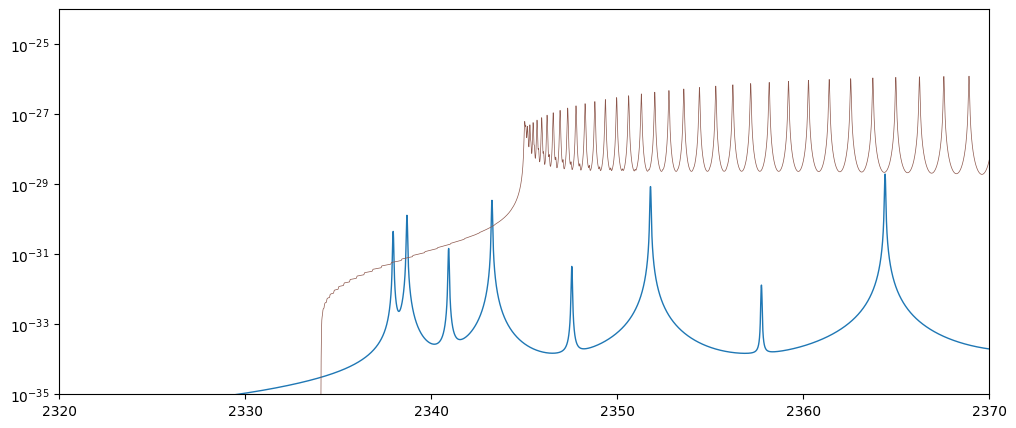

In [5]:
plt.figure(figsize=(12,5))
plt.plot(
    #wave, flux_HD * 0.75*4e-5, c='C0', lw=1, alpha=1
    wave, flux_HD * 0.75*1e-4, c='C0', lw=1, alpha=1
    )
plt.plot(
    wave, flux_13CO * 10**(-6.0), c='C5', lw=0.5, alpha=1
    )
#plt.xlim(2340,6000)
plt.xlim(2320,2370)
plt.yscale('log')
plt.ylim(1e-35,1e-24)
plt.show()

## Corner plots

In [ ]:
res = read_results(
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_186/test_', n_params=30
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_20/test_', n_params=20
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_187/test_', n_params=33
    prefix='./retrieval_outputs/DENIS_J0255_nominal_5/test_', n_params=32
    #prefix='./retrieval_outputs/DENIS_J0255_H2O_HITEMP/test_', n_params=32
    )
posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_', n_params=29
    )
posterior_2, bestfit_2, PT_2, Chem_2, int_contr_em_2, int_contr_em_per_order_2, int_opa_cloud_2, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_wo_Pquench_13CO/test_', n_params=28
    )
posterior_3, bestfit_3, PT_3, Chem_3, int_contr_em_3, int_contr_em_per_order_3, int_opa_cloud_3, m_spec_3, d_spec_3, LogLike_3, Cov_3, bestfit_params_3 = res

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_3[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_3.shape[1])]
    )
#print(param_quantiles[9]-param_quantiles[9][1])
#print(param_quantiles[[5,6]]-param_quantiles[[5,6],1])
#print(param_quantiles[[5,6]])
print(param_quantiles[5]-param_quantiles[5][1])
print(param_quantiles[6]-param_quantiles[6][1])

In [ ]:
posterior_color_1 = '#8B077C'
#posterior_color_1 = '#F76FE7'

posterior_color_2 = '#075B56'
#posterior_color_2 = '#F2B592'

posterior_color_3 = '#C25617'
#posterior_color_3 = '#6BFBF2'

'''
plt.plot(PT_1.temperature, PT_1.pressure)
plt.plot(PT_2.temperature, PT_2.pressure)
plt.ylim(1e2,1e-6)
plt.yscale('log')
plt.show()

plt.plot(Chem_2.mass_fractions['NH3_coles_main_iso'], PT_2.pressure, 'C0-')
plt.plot(Chem_2.mass_fractions['CH4_hargreaves_main_iso'], PT_2.pressure, 'C1-')
plt.plot(Chem_2.mass_fractions['CO2_main_iso'], PT_2.pressure, 'C2-')
plt.plot(Chem_2.mass_fractions['HCN_main_iso'], PT_2.pressure, 'C3-')

#Chem_2(bestfit_params_2['params'], PT_1.temperature)
plt.plot(Chem_2.mass_fractions['NH3_coles_main_iso'], PT_2.pressure, 'C0--')
plt.plot(Chem_2.mass_fractions['CH4_hargreaves_main_iso'], PT_2.pressure, 'C1--')
plt.plot(Chem_2.mass_fractions['CO2_main_iso'], PT_2.pressure, 'C2--')
plt.plot(Chem_2.mass_fractions['HCN_main_iso'], PT_2.pressure, 'C3--')

plt.ylim(1e2,1e-6)
plt.xlim(1e-8,1e0)
plt.yscale('log')
plt.xscale('log')
plt.show()

#dir(Chem_2)
#Chem_2
#mass_fractions['NH3_coles_main_iso']
'''

In [ ]:
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_synthetic_new/test_', n_params=19
    )
posterior_synth, bestfit_synth, PT_synth, Chem_synth, int_contr_em_synth, int_contr_em_per_order_synth, int_opa_cloud_synth, m_spec_synth, d_spec_synth, LogLike_synth, Cov_synth, bestfit_params_synth = res

posterior_color_synth = '#180d91'

bins = 20

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_synth, posterior_color_synth], 
    )
envelope_colors_synth = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors_synth[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])

indices = [0,1,3,7,4,5,6,2,8,9]
labels = [
    r'$R\ (R_\mathrm{Jup})$', #r'$R$', 
    r'$\log\ g$', #r'$\log\ g\ (\mathrm{cm\ s^{-2}})$',
    r'$\log\ \mathrm{^{12}CO}$', 
    r'$\log\ ^{13}\mathrm{CO}$', 
    r'$\log\ \mathrm{H_2O}$', 
    r'$\log\ \mathrm{CH_4}$', 
    r'$\log\ \mathrm{NH_3}$', 
    r'$\varepsilon_\mathrm{limb}$', 
    r'$v\ \sin i\ (\mathrm{km\ s^{-1}})$', 
    r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
    ]

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_synth[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_synth.shape[1])]
    )
# Base the axes-limits off of the quantiles
param_range = np.array(
    #[(3*(q_i[0]-q_i[1])+q_i[1], 3*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    #[(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    [(5*(q_i[0]-q_i[1])+q_i[1], 5*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    )
    
median_params = np.array(list(param_quantiles[:,1]))

fig = plt.figure(figsize=(11,11), )#facecolor='k')

fig = corner.corner(
    posterior_synth[:,indices], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    labelpad=0.18, 
    range=param_range[indices], 
    bins=bins, 
    max_n_ticks=2, 

    quantiles=[0.16,0.84,0.50], 
    color=posterior_color_synth, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':posterior_color_synth, 
        'facecolor':envelope_colors_synth[1], 
        'fill':True
        }, 

    #levels=(1-np.exp(-0.5),),
    fill_contours=True, 
    plot_datapoints=True, 
    #plot_datapoints=False, 

    contourf_kwargs={'colors':envelope_colors_synth}, 
    smooth=False, 

    contour_kwargs={'linewidths':0.5}, 
    )

# Add the truth values
corner.overplot_lines(fig, [0.8,5.25,-3.3,-5.5,-3.6,-4.9,-6.0,0.65,41.0,22.5], c='darkorange', lw=1)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].tick_params(top=(i!=j), right=(i!=j), direction='inout')

for i in range(ax.shape[0]):
    # Change linestyle of 16/84th percentile in histograms
    ax[i,i].get_lines()[0].set(linewidth=1, linestyle=(5,(5,5)))
    ax[i,i].get_lines()[1].set(linewidth=1, linestyle=(5,(5,5)))

    ax[i,i].get_lines()[2].set(linewidth=1, linestyle='-')

    ax[i,i].set_title(ax[i,i].get_title().replace(' = ', '\n'), fontsize=11)

    # Adjust the axis-limits
    for j in range(i):
        ax[i,j].set(ylim=param_range[indices][i])
    for h in range(ax.shape[0]):
        ax[h,i].set(xlim=param_range[indices][i])

    new_label = ax[-1,i].get_xlabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[-1,i].set_xlabel(new_label, fontsize=11)

    new_label = ax[i,0].get_ylabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[i,0].set_ylabel(new_label, fontsize=11)

#plt.rcParams.update({'text.usetex':False})
ax[0,3].plot([0,0], [np.nan,np.nan], lw=1, c='darkorange', label=r'$\bf{Input\ parameters:}$')
ax[0,3].plot([0,0], [np.nan,np.nan], lw=1, c='none', 
    #label=r'\begin{eqnarray*} $R$ &= 0.8\ $R_\mathrm{Jup}$ \\ $\log g$ &= 5.25 \\ $\log\ \mathrm{^{12}CO}$=-3.3 \end{eqnarray*}'
    label=
    r'$R\ \ \ \ \ \ \ \ \ =0.8\ R_\mathrm{Jup}$' + '\n' + 
    r'$\log g\ \ \ \ =5.25$' + '\n' + 
    r'$\log\ \mathrm{^{12}CO}=-3.3$' + '\n' +
    r'$\log\ ^{13}\mathrm{CO}=-5.5$' + '\n' +
    r'$\log\ \mathrm{H_2O}\ =-3.6$' + '\n' +
    r'$\log\ \mathrm{CH_4}\ =-4.9$' + '\n' +
    r'$\log\ \mathrm{NH_3}\ =-6.0$' + '\n' +
    r'$\varepsilon_\mathrm{limb}\ \ \ \ =0.65$' + '\n' +
    r'$v\ \sin i\ \ =41.0\ \mathrm{km\ s^{-1}}$' + '\n' +
    r'$v_\mathrm{rad}\ \ \ \ \ =22.5\ \mathrm{km\ s^{-1}}$'
    )
ax[0,3].legend(
    loc='upper left', bbox_to_anchor=[0.08,1.27], 
    handlelength=1.2, handletextpad=0.5, labelspacing=0.6
    )


l, r = 0.07, 0.95
b, t = 0.07, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

#x0, y0 = 0.59, 0.59
#x0, y0 = 0.62, 0.62; r, t = 0.97, 0.97
x0, y0 = 0.59, 0.59; r, t = 0.97, 0.97
ax_PT = fig.add_axes([x0,y0,r-x0,t-y0])#, autoscale_on=False)
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(0,3500), xlabel=r'$T\ (\mathrm{K})$', 
    #facecolor='k'
    )
ax_PT.invert_yaxis()

ax_PT.set_xlabel(ax_PT.get_xlabel(), fontsize=11)
plt.xticks(fontsize=11)
ax_PT.set_ylabel(ax_PT.get_ylabel(), fontsize=11)
plt.yticks(fontsize=11)

leg_handles, leg_labels = [], []
for i in range(3):
    
    c = ax_PT.fill_betweenx(
        y=PT_synth.pressure, x1=PT_synth.temperature_envelopes[i], 
        x2=PT_synth.temperature_envelopes[i+1], 
        color=envelope_colors_synth[i+1], ec='none', 
        )
    #leg_handles.append(c); leg_labels.append(r'$'+f'{3-i}'+'\sigma$')
    leg_handles.append(c); leg_labels.append([r'$99\%$', r'$95\%$', r'$68\%$'][i])

    ax_PT.fill_betweenx(
        y=PT_synth.pressure, x1=PT_synth.temperature_envelopes[-i-2], 
        x2=PT_synth.temperature_envelopes[-i-1], 
        color=envelope_colors_synth[i+1], ec='none', 
        )

# Plot the median PT
ax_PT.plot(
    PT_synth.temperature_envelopes[3], PT_synth.pressure, 
    c=posterior_color_synth, lw=1
    )

'''
T = 1400; g = 1780
SONORA_pressure, SONORA_temperature, _, _ = np.genfromtxt(
    f'./data/SONORA_PT_structures/structures_m+0.0/t{T}g{g}nc_m0.0.dat', 
    skip_header=1, usecols=(1,2,4,5), delimiter=(3,12,10,11,8,8)
    ).T
l = ax_PT.plot(SONORA_temperature, SONORA_pressure, c='darkorange', lw=1.5, alpha=0.9)
'''

SONORA_temperature = np.loadtxt('./retrieval_outputs/DENIS_J0255_synthetic_new/test_data/SONORA_temperature.dat')
l = ax_PT.plot(SONORA_temperature, PT_synth.pressure, c='darkorange', lw=1.5, alpha=0.9)
leg_handles.append(*l); leg_labels.append(r'$\bf{Input\ Sonora\ PT\ profile:}$'+'\n'+r'$T_\mathrm{eff}=1400\ \mathrm{K},\ \log\ g=5.25$')

SONORA_RCB_P = np.loadtxt('./retrieval_outputs/DENIS_J0255_synthetic_new/test_data/SONORA_RCB.dat')
SONORA_RCB_T = np.interp(SONORA_RCB_P, PT_synth.pressure, SONORA_temperature)
ax_PT.plot(SONORA_RCB_T, SONORA_RCB_P, '-o', c='darkorange', lw=1.5, alpha=0.9)
#ax_PT.text
ax_PT.text(SONORA_RCB_T, SONORA_RCB_P+5, s='RCB', ha='right', va='top', color='darkorange', fontsize=11, alpha=0.9)

ax_contr = ax_PT.twiny()
l = ax_contr.plot(int_contr_em_synth, PT_synth.pressure, c='k', ls='--')#, alpha=0.7)
leg_handles.append(*l); leg_labels.append('Emission contribution')

ax_contr.set(xlim=(0, 1.05*np.nanmax(int_contr_em_synth)))
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

xy_legend = [1,0.5]
ax_PT.legend(leg_handles[:3], leg_labels[:3], 
    loc='upper right', bbox_to_anchor=xy_legend, ncol=3, 
    handlelength=1.5, handletextpad=0.5, columnspacing=1.1, 
    reverse=True
    )
xy_legend[1] = xy_legend[1]-0.02
ax_contr.legend(leg_handles[3:], leg_labels[3:], 
    loc='lower right', bbox_to_anchor=xy_legend, ncol=1, 
    handlelength=1.2, 
    )

fig.savefig('./plots/synthetic_corner.pdf')
plt.close(fig)

In [ ]:
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_wo_GPs/test_', n_params=24
    )
posterior_wo_GPs, bestfit_wo_GPs, PT_wo_GPs, Chem_wo_GPs, int_contr_em_wo_GPs, int_contr_em_per_order_wo_GPs, int_opa_cloud_wo_GPs, m_spec_wo_GPs, d_spec_wo_GPs, LogLike_wo_GPs, Cov_wo_GPs, bestfit_params_wo_GPs = res

posterior_color_wo_GPs = '#106beb'
#posterior_color_wo_GPs = posterior_color_synth
#posterior_color_wo_GPs = '#068c5b'
#posterior_color_wo_GPs = '#d11c00'
#posterior_color_wo_GPs = '#bf0000'
posterior_color_wo_GPs = '#bd0502'

bins = 25

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_wo_GPs, posterior_color_wo_GPs], 
    )
envelope_colors_wo_GPs = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors_wo_GPs[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])

indices = [0,1,8,12,9,10,11,2,3,4]
labels = [
    r'$R\ (R_\mathrm{Jup})$', #r'$R$', 
    r'$\log\ g$', #r'$\log\ g\ (\mathrm{cm\ s^{-2}})$',
    r'$\log\ \mathrm{^{12}CO}$', 
    r'$\log\ ^{13}\mathrm{CO}$', 
    r'$\log\ \mathrm{H_2O}$', 
    r'$\log\ \mathrm{CH_4}$', 
    r'$\log\ \mathrm{NH_3}$', 
    r'$\varepsilon_\mathrm{limb}$', 
    r'$v\ \sin i\ (\mathrm{km\ s^{-1}})$', 
    r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
    ]

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_wo_GPs[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_wo_GPs.shape[1])]
    )
# Base the axes-limits off of the quantiles
param_range = np.array(
    #[(3*(q_i[0]-q_i[1])+q_i[1], 3*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    #[(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    #[(5*(q_i[0]-q_i[1])+q_i[1], 5*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    [(10*(q_i[0]-q_i[1])+q_i[1], 10*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    )
    
median_params = np.array(list(param_quantiles[:,1]))

print(np.median(Chem_wo_GPs.CO_posterior), af.quantiles(Chem_wo_GPs.CO_posterior, q=[0.16,0.84])-np.median(Chem_wo_GPs.CO_posterior))
print(np.median(Chem_wo_GPs.FeH_posterior), af.quantiles(Chem_wo_GPs.FeH_posterior, q=[0.16,0.84])-np.median(Chem_wo_GPs.FeH_posterior))

Chem_wo_GPs.C_ratio_posterior = 10**posterior_wo_GPs[:,8] / 10**posterior_wo_GPs[:,12]
print(np.median(Chem_wo_GPs.C_ratio_posterior), af.quantiles(Chem_wo_GPs.C_ratio_posterior, q=[0.16,0.84])-np.median(Chem_wo_GPs.C_ratio_posterior))

param_range = np.array([
    (0.68,0.82), 
    (5.15,5.5), 
    (-3.41,-3.23), 
    (-6.0,-5.25), 
    (-3.7,-3.5), 
    (-5.03,-4.76), 
    (-6.15,-5.75), 
    (0.48,0.75), 
    (39.65,41.75), 
    (22.25,22.8), 
])

fig = plt.figure(figsize=(11,11))

fig = corner.corner(
    posterior_1[:,[8,9,16,20,17,18,19,10,11,12]], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    labelpad=0.18, 
    #range=param_range[indices], 
    range=param_range, 
    bins=bins, 
    max_n_ticks=2, 

    #quantiles=[0.16,0.84,0.50], 
    color=posterior_color_1, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':envelope_colors_1[3], 
        'facecolor':np.concatenate((envelope_colors_1[1,:3],[0.1])), 
        'fill':True, 
        'linewidth':0.7
        #'alpha':0.5
        }, 

    fill_contours=False, 
    #fill_contours=True, 
    plot_datapoints=False,  
    #plot_datapoints=True,  
    plot_density=False, 
    no_fill_contours=True, 
    #no_fill_contours=False, 
    smooth=False, 
    contourf_kwargs={'colors':envelope_colors_1}, 
    #contour_kwargs={'linewidths':1, 'colors':envelope_colors_1[3]}, 
    contour_kwargs={'linewidths':0.7, 'colors':envelope_colors_1[2]},
    )

fig = corner.corner(
    posterior_wo_GPs[:,indices], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    labelpad=0.18, 
    #range=param_range[indices], 
    range=param_range, 
    bins=bins, 
    max_n_ticks=2, 

    quantiles=[0.16,0.84,0.50], 
    color=posterior_color_wo_GPs, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':posterior_color_wo_GPs, 
        'facecolor':envelope_colors_wo_GPs[1], 
        'fill':True
        }, 

    #levels=(1-np.exp(-0.5),),
    fill_contours=True, 
    plot_datapoints=True, 
    #plot_datapoints=False, 

    contourf_kwargs={'colors':envelope_colors_wo_GPs}, 
    smooth=False, 

    contour_kwargs={'linewidths':0.5}, 
    )

# Add the truth values
#corner.overplot_lines(fig, [0.8,5.25,-3.3,-5.5,-3.6,-4.9,-6.0,0.65,41.0,22.5], c='darkorange', lw=1)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].tick_params(top=(i!=j), right=(i!=j), direction='inout')

for i in range(ax.shape[0]):
    # Change linestyle of 16/84th percentile in histograms
    ax[i,i].get_lines()[0].set(linewidth=1, linestyle=(5,(5,5)))
    ax[i,i].get_lines()[1].set(linewidth=1, linestyle=(5,(5,5)))

    ax[i,i].get_lines()[2].set(linewidth=1, linestyle='-')

    ax[i,i].set_title(ax[i,i].get_title().replace(' = ', '\n'), fontsize=11)

    # Adjust the axis-limits
    for j in range(i):
        #ax[i,j].set(ylim=param_range[indices][i])
        ax[i,j].set(ylim=param_range[i])
    for h in range(ax.shape[0]):
        #ax[h,i].set(xlim=param_range[indices][i])
        ax[h,i].set(xlim=param_range[i])

    new_label = ax[-1,i].get_xlabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[-1,i].set_xlabel(new_label, fontsize=11)

    new_label = ax[i,0].get_ylabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[i,0].set_ylabel(new_label, fontsize=11)


l, r = 0.07, 0.95
b, t = 0.07, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

#x0, y0 = 0.59, 0.59
#x0, y0 = 0.62, 0.62; r, t = 0.97, 0.97
x0, y0 = 0.59, 0.59; r, t = 0.97, 0.97
ax_PT = fig.add_axes([x0,y0,r-x0,t-y0])#, autoscale_on=False)
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(0,3500), xlabel=r'$T\ (\mathrm{K})$', 
    #facecolor='k'
    )
ax_PT.invert_yaxis()

ax_PT.set_xlabel(ax_PT.get_xlabel(), fontsize=11)
plt.xticks(fontsize=11)
ax_PT.set_ylabel(ax_PT.get_ylabel(), fontsize=11)
plt.yticks(fontsize=11)

leg_handles, leg_labels = [], []
for i in range(3):
    
    c = ax_PT.fill_betweenx(
        y=PT_wo_GPs.pressure, x1=PT_wo_GPs.temperature_envelopes[i], 
        x2=PT_wo_GPs.temperature_envelopes[i+1], 
        color=envelope_colors_wo_GPs[i+1], ec='none', 
        )
    leg_handles.append(c); leg_labels.append([r'$99\%$', r'$95\%$', r'$68\%$'][i])

    ax_PT.fill_betweenx(
        y=PT_wo_GPs.pressure, x1=PT_wo_GPs.temperature_envelopes[-i-2], 
        x2=PT_wo_GPs.temperature_envelopes[-i-1], 
        color=envelope_colors_wo_GPs[i+1], ec='none', 
        )

    #'''
    color_i = np.copy(envelope_colors_1[i+1])
    color_i[-1] /= 2
    ax_PT.fill_betweenx(
        y=PT_1.pressure, x1=PT_1.temperature_envelopes[i], 
        x2=PT_1.temperature_envelopes[i+1], 
        color=color_i, ec='none', 
        )
    ax_PT.fill_betweenx(
        y=PT_1.pressure, x1=PT_1.temperature_envelopes[-i-2], 
        x2=PT_1.temperature_envelopes[-i-1], 
        color=color_i, ec='none', 
        )
    #'''
    '''
    ax_PT.plot(
        PT_1.temperature_envelopes[i], PT_1.pressure, 
        c=envelope_colors_1[2], lw=1
        )
    ax_PT.plot(
        PT_1.temperature_envelopes[-i-1], PT_1.pressure, 
        c=envelope_colors_1[2], lw=1
        )
    '''

# Plot the median PT
ax_PT.plot(
    PT_wo_GPs.temperature_envelopes[3], PT_wo_GPs.pressure, 
    c=posterior_color_wo_GPs, lw=1
    )
ax_PT.plot(
    PT_1.temperature_envelopes[3], PT_1.pressure, 
    c=envelope_colors_1[3], lw=0.7
    )

ax[0,2].fill_betweenx(
    y=PT_wo_GPs.pressure, x1=np.nan*PT_wo_GPs.temperature_envelopes[-i-2], 
    x2=np.nan*PT_wo_GPs.temperature_envelopes[-i-1], 
    color=envelope_colors_wo_GPs[1], 
    ec=posterior_color_wo_GPs, label=r'Without Gaussian Processes'
    )
ax[0,2].fill_betweenx(
    y=PT_1.pressure, x1=np.nan*PT_1.temperature_envelopes[-i-2], 
    x2=np.nan*PT_1.temperature_envelopes[-i-1], 
    color=np.concatenate((envelope_colors_1[1,:3],[0.1])), 
    ec=envelope_colors_1[3], linewidth=0.7, label=r'Fiducial retrieval (with GPs)'
    )
ax[0,2].legend(
    loc='upper left', bbox_to_anchor=[0,1], 
    handlelength=1.5, handletextpad=0.5, #labelspacing=0.6
)

ax_contr = ax_PT.twiny()
l = ax_contr.plot(int_contr_em_wo_GPs, PT_wo_GPs.pressure, c='k', ls='--')#, alpha=0.7)
leg_handles.append(*l); leg_labels.append('Emission contribution')

ax_contr.set(xlim=(0, 1.05*np.nanmax(int_contr_em_wo_GPs)))
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

xy_legend = [1,0.5]
ax_PT.legend(leg_handles[:3], leg_labels[:3], 
    loc='upper right', bbox_to_anchor=xy_legend, ncol=3, 
    handlelength=1.5, handletextpad=0.5, columnspacing=1.1, 
    reverse=True
    )
xy_legend[1] = xy_legend[1]-0.02
ax_contr.legend(leg_handles[3:], leg_labels[3:], 
    loc='lower right', bbox_to_anchor=xy_legend, ncol=1, 
    handlelength=1.2, 
    )

fig.savefig('./plots/wo_GPs_corner.pdf')
plt.close(fig)

In [ ]:
#posterior_color_1 = 'C0'
#posterior_color_1 = plt.get_cmap('RdPu')(0.9)
#posterior_color_1 = plt.get_cmap('RdPu')(0.85)
bestfit_color = plt.get_cmap('Reds')(0.6)
bins = 20

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_1, posterior_color_1], 
    )
envelope_colors_1 = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors_1[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])

#indices = [0,1,3,7,4,5,6]
indices = [
    8,9,16,20,17,18,19, 
    10,11,12
]
labels = [
    r'$R\ (R_\mathrm{Jup})$', #r'$R$', 
    r'$\log\ g$', #r'$\log\ g\ (\mathrm{cm\ s^{-2}})$',
    r'$\log\ \mathrm{^{12}CO}$', 
    r'$\log\ ^{13}\mathrm{CO}$', 
    r'$\log\ \mathrm{H_2O}$', 
    r'$\log\ \mathrm{CH_4}$', 
    r'$\log\ \mathrm{NH_3}$', 
    r'$\varepsilon_\mathrm{limb}$', 
    r'$v\ \sin i\ (\mathrm{km\ s^{-1}})$', 
    r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
    ]

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_1[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_1.shape[1])]
    )
# Base the axes-limits off of the quantiles
param_range = np.array(
    #[(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    [(5*(q_i[0]-q_i[1])+q_i[1], 5*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    )
    
median_params = np.array(list(param_quantiles[:,1]))

fig = plt.figure(figsize=(11,11), )#facecolor='k')

fig = corner.corner(
    posterior_1[:,indices], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    labelpad=0.18, 
    range=param_range[indices], 
    bins=bins, 
    max_n_ticks=2, 

    quantiles=[0.16,0.84,0.50], 
    color=posterior_color_1, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':posterior_color_1, 
        'facecolor':envelope_colors_1[1], 
        'fill':True
        }, 

    #levels=(1-np.exp(-0.5),),
    fill_contours=True, 
    plot_datapoints=True, 
    #plot_datapoints=False, 

    contourf_kwargs={'colors':envelope_colors_1}, 
    smooth=False, 

    contour_kwargs={'linewidths':0.5}, 
    )

# Add the best-fit and median values as lines
#corner.overplot_lines(fig, self.bestfit_params[mask_params], c=self.bestfit_color, lw=0.5)
#corner.overplot_lines(fig, median_params[indices], c=posterior_color_1, lw=1)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].tick_params(top=(i!=j), right=(i!=j), direction='inout')
        
        #if len(ax[i,j].collections) > 0:
        #    ax[i,j].collections[0].set_visible(False)
        #ax[i,j].set(facecolor='k')

for i in range(ax.shape[0]):
    # Change linestyle of 16/84th percentile in histograms
    ax[i,i].get_lines()[0].set(linewidth=1, linestyle=(5,(5,5)))
    ax[i,i].get_lines()[1].set(linewidth=1, linestyle=(5,(5,5)))

    ax[i,i].get_lines()[2].set(linewidth=1, linestyle='-')

    ax[i,i].set_title(ax[i,i].get_title().replace(' = ', '\n'), fontsize=11)

    # Adjust the axis-limits
    for j in range(i):
        ax[i,j].set(ylim=param_range[indices][i])
    for h in range(ax.shape[0]):
        ax[h,i].set(xlim=param_range[indices][i])

    new_label = ax[-1,i].get_xlabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[-1,i].set_xlabel(new_label, fontsize=11)

    new_label = ax[i,0].get_ylabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[i,0].set_ylabel(new_label, fontsize=11)

l, r = 0.07, 0.95
b, t = 0.07, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

#x0, y0 = 0.59, 0.59
#x0, y0 = 0.62, 0.62; r, t = 0.97, 0.97
x0, y0 = 0.59, 0.59; r, t = 0.97, 0.97
ax_PT = fig.add_axes([x0,y0,r-x0,t-y0])#, autoscale_on=False)
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(0,3500), xlabel=r'$T\ (\mathrm{K})$', 
    #facecolor='k'
    )
ax_PT.invert_yaxis()

ax_PT.set_xlabel(ax_PT.get_xlabel(), fontsize=11)
plt.xticks(fontsize=11)
ax_PT.set_ylabel(ax_PT.get_ylabel(), fontsize=11)
plt.yticks(fontsize=11)

leg_handles, leg_labels = [], []
for i in range(3):
    
    c = ax_PT.fill_betweenx(
        y=PT_1.pressure, x1=PT_1.temperature_envelopes[i], 
        x2=PT_1.temperature_envelopes[i+1], 
        color=envelope_colors_1[i+1], ec='none', 
        )
    #leg_handles.append(c); leg_labels.append(r'$'+f'{3-i}'+'\sigma$')
    leg_handles.append(c); leg_labels.append([r'$99\%$', r'$95\%$', r'$68\%$'][i])

    ax_PT.fill_betweenx(
        y=PT_1.pressure, x1=PT_1.temperature_envelopes[-i-2], 
        x2=PT_1.temperature_envelopes[-i-1], 
        color=envelope_colors_1[i+1], ec='none', 
        )

# Plot the median PT
ax_PT.plot(
    PT_1.temperature_envelopes[3], PT_1.pressure, 
    c=posterior_color_1, lw=1
    )

T = 1400; g = 1780
SONORA_pressure, SONORA_temperature, _, _ = np.genfromtxt(
    f'./data/SONORA_PT_structures/structures_m+0.0/t{T}g{g}nc_m0.0.dat', 
    skip_header=1, usecols=(1,2,4,5), delimiter=(3,12,10,11,8,8)
    ).T
l = ax_PT.plot(SONORA_temperature, SONORA_pressure, c='darkorange', lw=1.5, alpha=0.9)
leg_handles.append(*l); leg_labels.append('Sonora Bobcat PT profile\n'+r'$T_\mathrm{eff}=1400\ \mathrm{K},\ \log\ g=5.25$')


def cloud_condensation_curves(pressure, FeH, cloud_species):

    coeffs = {
        'CaTiO3': [5.125, -0.277, -0.554], # Wakeford et al. (2017)
        'Fe': [5.44, -0.48, -0.48], # Visscher et al. (2010)
        'Mg2SiO4': [5.89, -0.37, -0.73], # Visscher et al. (2010)
        'MgSiO3': [6.26, -0.35, -0.70], # Visscher et al. (2010)
        'Cr': [6.576, -0.486, -0.486], # Morley et al. (2012)
        'KCl': [12.479, -0.879, -0.879], # Morley et al. (2012)
        'MnS': [7.45, -0.42, -0.84], # Visscher et al. (2006)
        'Na2S': [10.05, -0.72, -1.08], # Visscher et al. (2006)
        'ZnS': [12.52, -0.63, -1.26], # Visscher et al. (2006)
        'H2S': [86.49, -8.54, -8.54], # Visscher et al. (2006)
    }

    a, b, c = coeffs[cloud_species]
    
    y = a + b*np.log10(pressure) + c*FeH
    T = 1e4/y

    return T

ls = (0,(3,2.8))
colors = ['g','r','b','teal']
P_ref = 0.35
ax_PT.plot(
    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='Fe'), PT_1.pressure, 
    c=colors[0], ls=ls, lw=1, alpha=0.75, zorder=1
    )
ax_PT.plot(
    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='Mg2SiO4'), PT_1.pressure, 
    c=colors[1], ls=ls, lw=1, alpha=0.75, zorder=1
    )
ax_PT.plot(
    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='MgSiO3'), PT_1.pressure, 
    c=colors[2], ls=ls, lw=1, alpha=0.75, zorder=1
    )
ax_PT.plot(
    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='MnS'), PT_1.pressure, 
    c=colors[3], ls=ls, lw=1, alpha=0.75, zorder=1
    )

ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'Fe'), P_ref, s='Fe', 
    ha='center', va='center', rotation=-68, color='w', fontsize=8, 
    bbox={'fc':'w', 'ec':'w', 'pad':2}
    )
ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'Mg2SiO4'), P_ref, s=r'Mg$_2$SiO$_4$', 
    ha='center', va='center', rotation=-76, color='w', fontsize=8, 
    bbox={'fc':'w', 'ec':'w', 'pad':2}
    )
ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'MgSiO3'), P_ref, s=r'MgSiO$_3$', 
    ha='center', va='center', rotation=-78, color='w', fontsize=8, 
    bbox={'fc':'w', 'ec':'w', 'pad':2}
    )
ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'MnS'), P_ref, s='MnS', 
    ha='center', va='center', rotation=-80, color='w', fontsize=8, 
    bbox={'fc':'w', 'ec':'w', 'pad':2}
    )

ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'Fe'), P_ref, s='Fe', 
    ha='center', va='center', rotation=-68, color=colors[0], fontsize=8, alpha=0.75
    )
ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'Mg2SiO4'), P_ref, s=r'Mg$_2$SiO$_4$', 
    ha='center', va='center', rotation=-76, color=colors[1], fontsize=8, alpha=0.75
    )
ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'MgSiO3'), P_ref, s=r'MgSiO$_3$', 
    ha='center', va='center', rotation=-78, color=colors[2], fontsize=8, alpha=0.75
    )
ax_PT.text(
    cloud_condensation_curves(P_ref, 0, 'MnS'), P_ref, s='MnS', 
    ha='center', va='center', rotation=-80, color=colors[3], fontsize=8, alpha=0.75
    )

#ax_PT.plot(
#    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='CaTiO3'), PT_1.pressure, c='C3', ls=ls, lw=1
#    )
#ax_PT.plot(
#    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='Cr'), PT_1.pressure, c='C5', ls=ls, lw=1
#    )
#ax_PT.plot(
#    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='Na2S'), PT_1.pressure, c='C6', ls=ls, lw=1
#    )
#ax_PT.plot(
#    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='ZnS'), PT_1.pressure, c='C7', ls=ls, lw=1
#    )
#ax_PT.plot(
#    cloud_condensation_curves(PT_1.pressure, FeH=0, cloud_species='KCl'), PT_1.pressure, c='C8', ls=ls, lw=1
#    )

ax_contr = ax_PT.twiny()
l = ax_contr.plot(int_contr_em_1, PT_1.pressure, c='k', ls='--')#, alpha=0.7)
leg_handles.append(*l); leg_labels.append('Emission contribution')

ax_contr.set(xlim=(0, 1.05*np.nanmax(int_contr_em_1)))
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

xy_legend = [1,0.65]
ax_PT.legend(leg_handles[:3], leg_labels[:3], 
    loc='upper right', bbox_to_anchor=xy_legend, ncol=3, 
    handlelength=1.5, handletextpad=0.5, columnspacing=1.1, 
    reverse=True
    )
xy_legend[1] = xy_legend[1]-0.02
ax_contr.legend(leg_handles[3:], leg_labels[3:], 
    loc='lower right', bbox_to_anchor=xy_legend, ncol=1, 
    handlelength=1.2, 
    )

fig.savefig('./plots/fiducial_corner.pdf')
#fig.savefig('./plots/H2O_HITEMP_corner.pdf')
plt.close(fig)

In [ ]:
def plot_hist1d(ax, posterior, ec, fc, xrange, bins=25, ls='-', ymarker=0.05, label=None):

    q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

    _, _, p = ax.hist(
        posterior, bins=bins, range=xrange, histtype='step', fill=True, 
        ec=ec, fc=fc, ls=ls, label=label, 
        )

    median = np.median(posterior)
    xerr = np.abs(np.quantile(posterior, q=q[[1,-2]])-median)[:,None]
    ax.errorbar(
        median, ymarker, xerr=xerr, 
        fmt='o', c=ec, capthick=2, elinewidth=2, transform=ax.get_xaxis_transform(), markersize=4
        )

    xerr = np.abs(np.quantile(posterior, q=q[[2,-3, 1,-2, 0,-1]])-median)[:,None]
    print('{:} | -{:}+{:} | -{:}+{:} | -{:}+{:}'.format(median, *xerr.flatten()))

    return p[0]

def plot_VMR_profile(ax, pressure, chem, species, ec, ls=['--','--'], plot_unquenched=False, plot_unquenched_envelope=False, relative_to_12CO=True):

    cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'cmap', colors=['w', ec]
            )
    fc = cmap(0.8)

    # Read MMW posterior
    MMW = chem.mass_fractions_posterior['MMW']
    
    if relative_to_12CO:
        mass = chem.read_species_info('12CO', info_key='mass')
        line_species = chem.read_species_info('12CO', info_key='pRT_name')
        posterior_12CO = MMW/mass * chem.mass_fractions_posterior[line_species]

    mass = chem.read_species_info(species, info_key='mass')
    line_species = chem.read_species_info(species, info_key='pRT_name')
    posterior_X = MMW/mass * chem.mass_fractions_posterior[line_species]

    if relative_to_12CO:
        posterior_X /= posterior_12CO

    envelope_X = np.array(
        [af.quantiles(posterior_X[:,i], q=q) for i in range(posterior_X.shape[1])]
        ).T

    if isinstance(ls, list):
        ls_1, ls_2 = ls
    else:
        ls_1 = ls
        ls_2 = ls
        
    ax.plot(
        envelope_X[3], pressure, c=ec, lw=1, ls=ls_1
        )
    ax.fill_betweenx(
        y=pressure, x1=envelope_X[1], x2=envelope_X[-2], 
        fc=fc, alpha=0.3, ec='none', #ec=colors[i], ls='--'
        )

    #print(line_species)
    #print(chem.unquenched_mass_fractions_posterior.keys())
    if hasattr(chem, 'P_quench') and plot_unquenched:
        if chem.P_quench < chem.pressure.min():
            return
        
        if chem.unquenched_mass_fractions.get(line_species) is None:
            return
        
        unquenched_mass_fractions_i = chem.unquenched_mass_fractions_posterior[line_species]
        unquenched_posterior_X = MMW/mass * unquenched_mass_fractions_i

        if relative_to_12CO:
            unquenched_posterior_X /= posterior_12CO

        unquenched_envelope_X = np.array(
            [af.quantiles(unquenched_posterior_X[:,i], q=q) 
             for i in range(unquenched_posterior_X.shape[1])]
            ).T

        ax.plot(
            unquenched_envelope_X[3], pressure, 
            c=ec, lw=1, ls=ls_2, alpha=0.5
            )
        if plot_unquenched_envelope:
            ax.fill_betweenx(
                y=pressure, x1=unquenched_envelope_X[1], x2=unquenched_envelope_X[-2], 
                fc=fc, alpha=0.3*0.5, ec='none', #ec=colors[i], ls='--'
                )

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])
#param_quantiles = np.array(
#    [af.quantiles(posterior_1[:,i], q=q) for i in range(posterior_1.shape[1])]
#    )
param_quantiles = np.array(
    [af.quantiles(10**posterior_1[:,i]/10**posterior_1[:,16], q=q) for i in range(posterior_1.shape[1])]
    )

fig = plt.figure(figsize=(10,4))

wspace = 0.05
gs = mpl.gridspec.GridSpec(ncols=6, nrows=2, figure=fig, width_ratios=[0.9,0.2,wspace,0.6,wspace,0.6], wspace=0.0, hspace=0.4)

ax_VMR = fig.add_subplot(gs[:,0])

colors = ['C2', 'C3', 'C4', 'C8', 'C5']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO']

y_1 = 0.085
for i, idx in enumerate([16,17,18,19,20]):

    #median = 10**param_quantiles[idx,3]/10**param_quantiles[16,3]
    #xerr = np.abs(10**param_quantiles[idx,:]/10**param_quantiles[16,3]-median)
    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, 
        #fmt='s', markersize=3, 
        transform=ax_VMR.get_xaxis_transform()
    )

    plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')
    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')


ax_VMR.annotate(
    text=labels[0], xy=(10**(0.05), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='left', color=colors[0], fontsize=9
)
ax_VMR.annotate(
    text=labels[1], xy=(10**(-0.35), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='right', color=colors[1], fontsize=9
)
ax_VMR.annotate(
    text=labels[2], xy=(10**(-1.5), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='left', color=colors[2], fontsize=9
)
ax_VMR.annotate(
    text=labels[3], xy=(10**(-2.77), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='right', color=colors[3], fontsize=9
)
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.06), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='left', color=colors[4], fontsize=9
)

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-3.5),10**(0.5)), xlabel=r'$\mathrm{VMR}\ /\ \mathrm{^{12}CO}$', 
    )
ax_VMR.invert_yaxis()

ax_hist1d = np.array([
    fig.add_subplot(gs[0,-3]), 
    fig.add_subplot(gs[1,-3]), 
    fig.add_subplot(gs[0,-1]), 
    fig.add_subplot(gs[1,-1]), 
])

labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    ax_i.set(xlabel=labels[i])

patches = []
CO_range = (0.53,0.71)
CO_bins = np.arange(CO_range[0], CO_range[1]+1e-6, 0.0025)

FeH_range = (-0.08,1.0)
FeH_bins = np.arange(FeH_range[0], FeH_range[1]+1e-6, 0.02)

C_ratio_range = (50,500)
C_ratio_bins = np.arange(C_ratio_range[0], C_ratio_range[1]+1e-6, 20)
# -------------------------------------------------------------

plot_hist1d(
    ax_hist1d[0], Chem_1.CO_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=CO_range, bins=CO_bins, ymarker=0.05
    )

plot_hist1d(
    ax_hist1d[1], Chem_1.FeH_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.05
    )

indices = [16,20,17,18,19]
Chem_1.C_ratio_posterior = 10**posterior_1[:,indices[0]] / 10**posterior_1[:,indices[1]]

p = plot_hist1d(
    ax_hist1d[2], Chem_1.C_ratio_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.05, label=r'Free-chemistry'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_2 = 'darkgoldenrod'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

plot_hist1d(
    ax_hist1d[0], Chem_2.CO_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=CO_range, bins=CO_bins, ymarker=0.1
    )

plot_hist1d(
    ax_hist1d[1], Chem_2.FeH_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.1
    )

Chem_2.C_ratio_posterior = 10**(-posterior_2[:,19])
p = plot_hist1d(
    ax_hist1d[2], Chem_2.C_ratio_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.1, 
    #label='Equilibrium chemistry\n' + r'with $P_\mathrm{quench}$'
    label='Quenched equilibrium chemistry'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_3 = 'teal'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

p = plot_hist1d(
    ax_hist1d[0], Chem_3.CO_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=CO_range, bins=CO_bins, ymarker=0.15, 
    #label='Equilibrium chemistry\n' + r'without $P_\mathrm{quench}$'
    label='Un-quenched equilibrium chemistry'
    )

plot_hist1d(
    ax_hist1d[1], Chem_3.FeH_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.15
    )

Chem_3.C_ratio_posterior = 10**(-posterior_3[:,19])
#plot_hist1d(
#    ax_hist1d[2], Chem_3.C_ratio_posterior, 
#    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
#    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.15, 
#    )
patches.append(p)

#ax_hist1d[0].set(xlim=(0.67,0.7))
#ax_hist1d[1].set(xlim=(-0.4,0.4))
#ax_hist1d[2].set(xlim=(90,160))
#ax_hist1d[3].set(xlim=())

ax_hist1d[3].legend(
    loc='center', bbox_to_anchor=(0.5,0.5), handles=patches, 
    framealpha=1, edgecolor='k', fancybox=False, labelspacing=1.2, 
    )
ax_hist1d[3].set_axis_off()


ax_contr = fig.add_subplot(gs[:,1])
#ax_contr.plot(int_contr_em_1, PT_1.pressure, c='k', ls='--')#, alpha=0.7)
ax_contr.plot(int_contr_em_1, PT_1.pressure, c=posterior_color_1, lw=1, ls='-')#, alpha=0.7)
ax_contr.plot(int_contr_em_2, PT_2.pressure, c=posterior_color_2, lw=1, ls='--')#, alpha=0.7)
ax_contr.plot(int_contr_em_3, PT_3.pressure, c=posterior_color_3, lw=1, ls=':')#, alpha=0.7)

ax_contr.set(xlim=(0, 1.05*np.nanmax(int_contr_em_1)), yscale='log', ylim=(1e2,1e-6), yticks=[], xticks=[])
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

ax_contr.errorbar(
    x=0.1, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench}$', xy=(0.17, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='top', ha='left', color=posterior_color_2, fontsize=9
)

l, r = 0.08, 0.97
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/chemistry.pdf')
plt.close(fig)

In [ ]:
def plot_PT_and_contr(ax_PT, ax_contr, PT, int_contr_em, envelope_colors, posterior_color, ls='-'):

    ax_PT.fill_betweenx(
        y=PT.pressure, x1=PT.temperature_envelopes[1], 
        x2=PT.temperature_envelopes[-2], 
        #color=envelope_colors[3], ec='none', 
        color=envelope_colors[2], ec='none', 
        )
    ax_PT.plot(
        PT.temperature_envelopes[3], PT.pressure, 
        c=posterior_color, lw=1, ls=ls
        )
    ax_contr.plot(
        int_contr_em, PT.pressure, c=posterior_color, lw=1, ls=ls
        )

fig = plt.figure(figsize=(9,4))

wspace = 0.05
gs = mpl.gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[0.8,1,wspace,0.5], wspace=0.0, hspace=0.35)

ax_VMR = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,1])

ax_hist1d = [
    fig.add_subplot(gs[0,-1]), 
    fig.add_subplot(gs[1,-1]), 
    fig.add_subplot(gs[2,-1]), 
]

# ==================================================================================
y_1 = 0.075
ax_VMR.plot(
    [0,1], [y_1,y_1], transform=ax_VMR.transAxes, 
    c=envelope_colors_1[1], lw=1
    )
ax_VMR.annotate(
    'Free-chem.', xy=(0.0,y_1), xycoords=ax_VMR.transAxes, 
    xytext=(-0.02,y_1), 
    va='center', ha='right', color=posterior_color_1, fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'arc3', 
        'shrinkA':25, 'shrinkB':0, 'lw':1, 'color':envelope_colors_1[1], 
        }
)
    
'''
colors = ['C6', 'C7']
labels = [r'CO$_2$', r'HCN']
species = ['CO2', 'HCN']

for i, idx in enumerate([21,22]):

    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, alpha=0.5,
        transform=ax_VMR.get_xaxis_transform()
    )

    plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')
    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')
'''

colors = ['C2', 'C3', 'C4', 'C8', 'C5']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO']

for i, idx in enumerate([16,17,18,19,20]):

    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, 
        transform=ax_VMR.get_xaxis_transform()
    )
    #plot_VMR_profile(ax_VMR, PT_1.pressure, Chem_1, species=species[i], ec=colors[i], ls='-')

    plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')

    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')

ax_VMR.annotate(
    text=labels[0], xy=(10**(0.02), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[0], fontsize=9
)
ax_VMR.annotate(
    text=labels[1], xy=(10**(-0.32), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[1], fontsize=9
)
ax_VMR.annotate(
    text=labels[2], xy=(10**(-1.55), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[2], fontsize=9
)
ax_VMR.annotate(
    text=labels[3], xy=(10**(-2.73), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[3], fontsize=9
)
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.2), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[4], fontsize=9
)

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-3.3),10**(0.6)), xlabel=r'$\mathrm{VMR}(X_i)\ /\ \mathrm{VMR(^{12}CO)}$', 
    #xscale='log', xlim=(10**(-8),10**(0.6)), xlabel=r'$\mathrm{VMR}(X_i)\ /\ \mathrm{VMR(^{12}CO)}$', 
    )
ax_VMR.invert_yaxis()

# ==================================================================================
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), yticks=[], #ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(1,2500), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax_PT.invert_yaxis()
    
ax_contr = ax_PT.twiny()

plot_PT_and_contr(ax_PT, ax_contr, PT_1, int_contr_em_1, envelope_colors_1, posterior_color_1, ls='-')
plot_PT_and_contr(ax_PT, ax_contr, PT_2, int_contr_em_2, envelope_colors_2, posterior_color_2, ls='--')
plot_PT_and_contr(ax_PT, ax_contr, PT_3, int_contr_em_3, envelope_colors_3, posterior_color_3, ls=':')

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

ax_contr.errorbar(
    x=0.05, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench}$', xy=(0.07, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='center', ha='left', color=posterior_color_2, fontsize=9
)

ax_contr.annotate(
    text=r'Emission contribution', 
    xy=(np.max(int_contr_em_3), PT_1.pressure[np.argmax(int_contr_em_3)]), 
    xytext=(1.2*np.max(int_contr_em_1), 11), 
    ha='center', va='top', fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=0', 
        'shrinkA':0, 'shrinkB':12, #'arrowstyle':']-',
        'lw':1, 'color':'k', 'alpha':0.2, 
        }
    )

ax_contr.set(xlim=(0, 3*np.nanmax(int_contr_em_1)), yscale='log', ylim=(1e2,1e-6), yticks=[], xticks=[])
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

# ==================================================================================
labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    #ax_i.set(xlabel=labels[i])
    ax_i.annotate(labels[i], xy=(0.98,0.95), xycoords='axes fraction', va='top', ha='right')

patches = []
CO_range = (0.53,0.71)
CO_bins = np.arange(CO_range[0], CO_range[1]+1e-6, 0.0025)

FeH_range = (-0.08,1.0)
FeH_bins = np.arange(FeH_range[0], FeH_range[1]+1e-6, 0.02)

C_ratio_range = (50,500)
C_ratio_bins = np.arange(C_ratio_range[0], C_ratio_range[1]+1e-6, 20)
# -------------------------------------------------------------

plot_hist1d(
    ax_hist1d[0], Chem_1.CO_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=CO_range, bins=CO_bins, ymarker=0.05
    )

plot_hist1d(
    ax_hist1d[1], Chem_1.FeH_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.05
    )

indices = [16,20,17,18,19]
Chem_1.C_ratio_posterior = 10**posterior_1[:,indices[0]] / 10**posterior_1[:,indices[1]]

p = plot_hist1d(
    ax_hist1d[2], Chem_1.C_ratio_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.05, label=r'Free-chemistry'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_2 = 'darkgoldenrod'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

plot_hist1d(
    ax_hist1d[0], Chem_2.CO_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=CO_range, bins=CO_bins, ymarker=0.1
    )

plot_hist1d(
    ax_hist1d[1], Chem_2.FeH_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.1
    )

Chem_2.C_ratio_posterior = 10**(-posterior_2[:,19])
p = plot_hist1d(
    ax_hist1d[2], Chem_2.C_ratio_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.1, 
    #label='Equilibrium chemistry\n' + r'with $P_\mathrm{quench}$'
    label='Quenched equilibrium\nchemistry'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_3 = 'teal'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

p = plot_hist1d(
    ax_hist1d[0], Chem_3.CO_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=CO_range, bins=CO_bins, ymarker=0.15, 
    #label='Equilibrium chemistry\n' + r'without $P_\mathrm{quench}$'
    label='Un-quenched\nequilibrium chemistry'
    )

plot_hist1d(
    ax_hist1d[1], Chem_3.FeH_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.15
    )

Chem_3.C_ratio_posterior = 10**(-posterior_3[:,19])
#plot_hist1d(
#    ax_hist1d[2], Chem_3.C_ratio_posterior, 
#    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
#    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.15, 
#    )
patches.append(p)

ax_hist1d[1].set(xticks=np.arange(0,1.25,0.25))
ax_hist1d[2].set(xticks=np.arange(100,600,100))

ax_PT.legend(
    loc='upper right', bbox_to_anchor=(1,0.7), handles=patches, 
    #framealpha=1, edgecolor='k', fancybox=False, 
    labelspacing=0.8, fontsize=9, handlelength=1.5, handleheight=0.9
    )

l, r = 0.09, 0.98
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

ax_PT.xaxis.labelpad = 6
ax_VMR.xaxis.labelpad = 3


fig.savefig('./plots/chemistry_PT.pdf')
plt.close(fig)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

colors = ['C2', 'C3', 'C4']#, 'C8', 'C5']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$']#, r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4']#, 'NH3', '13CO']

for color_i, label_i, species_i in zip(colors, labels, species):
    plot_VMR_profile(
        ax, PT_2.pressure, Chem_2, species_i, ec=color_i, ls=['--',(0,(6,4))], 
        plot_unquenched=True, plot_unquenched_envelope=True, relative_to_12CO=False
    )

ax.plot([-10,-10], [1e-8,1e-8], c='k', alpha=1.0, ls='--', label='Quenched')
ax.plot([-10,-10], [1e-8,1e-8], c='k', alpha=0.5, ls=(0,(6,4)), label='Un-quenched')

y_1 = 0.068
ax.annotate(
    text=labels[0], xy=(10**(-3.21), y_1), xycoords=ax.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[0], fontsize=9
)
ax.annotate(
    text=labels[1], xy=(10**(-3.59), y_1), xycoords=ax.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[1], fontsize=9
)
ax.annotate(
    text=labels[2], xy=(10**(-5.15), y_1), xycoords=ax.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[2], fontsize=9
)

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

ax.errorbar(
    x=0.05, y=median, yerr=yerr[:,None], transform=ax.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax.annotate(
    text=r'$P_\mathrm{quench}$', xy=(0.035, median-17), xycoords=ax.get_yaxis_transform(), 
    va='center', ha='left', color=posterior_color_2, fontsize=9
)

ax.plot(
    [1e-10,1e-2], [median]*2, c=posterior_color_2, lw=1, ls='-'
    )
ax.fill_between(
    x=[1e-10,1e-2], y1=[median-yerr[0]]*2, y2=[median+yerr[1]]*2, 
    fc=envelope_colors_2[2], alpha=0.3, ec='none', #ec=colors[i], ls='--'
    )

#plot_PT_and_contr(ax_PT, ax_contr, PT_2, int_contr_em_2, envelope_colors_2, posterior_color_2, ls='--')
ax_contr = ax.twiny()
ax_contr.plot(
    int_contr_em_2, PT_2.pressure, c=posterior_color_2, lw=1, ls='--'
    )
ax_contr.set(xlim=(0, 4*int_contr_em_2.max()), xticks=[], yticks=[])

ax.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-6),10**(-2.89)), xlabel=r'$\mathrm{VMR}$', 
    )
ax.invert_yaxis()

ax.legend(
    loc='upper left', bbox_to_anchor=(0,0.95), 
    #handles=patches, 
    #framealpha=1, edgecolor='k', fancybox=False, 
    labelspacing=0.5, fontsize=9, handlelength=2.3, handleheight=0.9
    )

l, r = 0.18, 0.96
b, t = 0.12, 0.96
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/VMR_profiles.pdf')
plt.close(fig)

### Transparent figure

In [ ]:
cmap = plt.get_cmap('RdPu')
posterior_color_1 = cmap(0.65)
envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_1, posterior_color_1], 
    )
envelope_colors_1 = envelope_cmap([0.0,0.2,0.4,0.5,0.8])
envelope_colors_1[:,-1] = np.array([0.0,0.2,0.35,0.5,0.65])
#envelope_colors_1[:,-1] = np.array([0.0,0.4,0.6,0.8,0.9])

#posterior_color_2 = '#0ca047'
#posterior_color_2 = '#075b33'
posterior_color_2 = '#0fbca5'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.35,0.5,0.65])

#posterior_color_3 = '#c26c17'
posterior_color_3 = '#ff6334'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.35,0.5,0.65])

fig = plt.figure(figsize=(9,4), 
    facecolor='none'
)

wspace = 0.05
#gs = mpl.gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[0.8,1,wspace,0.5], wspace=0.0, hspace=0.35)
wspace = 0.25
gs = mpl.gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[0.6,1,wspace,0.5], wspace=0.0, hspace=0.35)

ax_VMR = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,1])

ax_hist1d = [
    fig.add_subplot(gs[0,-1]), 
    fig.add_subplot(gs[1,-1]), 
    fig.add_subplot(gs[2,-1]), 
]

for ax_i in [ax_VMR, ax_PT, *ax_hist1d]:
    ax_i.set_facecolor('none')
    #ax_i.set_facecolor('k')

    ax_i.spines['bottom'].set_color(color_axis)
    ax_i.spines['top'].set_color(color_axis)
    ax_i.spines['right'].set_color(color_axis)
    ax_i.spines['left'].set_color(color_axis)

    ax_i.tick_params(axis='x', colors=color_axis, which='both')
    ax_i.tick_params(axis='y', colors=color_axis, which='both')
    ax_i.yaxis.label.set_color(color_axis)
    ax_i.xaxis.label.set_color(color_axis)

# ==================================================================================
y_1 = 0.075
ax_VMR.plot(
    [0,1], [y_1,y_1], transform=ax_VMR.transAxes, lw=1, 
    #c=envelope_colors_1[1], lw=1
    c=bestfit_color, alpha=0.7
    )
ax_VMR.annotate(
    #'Free chem.', xy=(0.0,y_1), xycoords=ax_VMR.transAxes, 
    'Free-chem.', xy=(0.0,y_1), xycoords=ax_VMR.transAxes, 
    xytext=(-0.02,y_1), 
    va='center', ha='right', #color=posterior_color_1, 
    fontsize=10, 
    color=mpl.colors.LinearSegmentedColormap.from_list(
            name='_', colors=['w', bestfit_color])(0.6),
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'arc3', 
        'shrinkA':25, 'shrinkB':0, 'lw':1, 
        #'color':envelope_colors_1[1], 
        'color':bestfit_color, 'alpha':0.5
        }
)
    
#colors = ['C2', 'C3', 'C4', 'C8', 'C5']
colors = ['C2', 'C0', 'C6', 'r', '#00d400']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO']

for i, idx in enumerate([16,17,18,19,20]):

    #median = 10**param_quantiles[idx,3]/10**param_quantiles[16,3]
    #xerr = np.abs(10**param_quantiles[idx,:]/10**param_quantiles[16,3]-median)
    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, 
        #fmt='s', markersize=3, 
        transform=ax_VMR.get_xaxis_transform()
    )
    #ax_VMR.hlines([y_1], xmin=0, xmax=1)
    
    #plot_VMR_profile(ax_VMR, PT_1.pressure, Chem_1, species=species[i], ec=colors[i], ls='-')

    #plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')
    #'''
    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')
    #'''


ax_VMR.annotate(
    text=labels[0], xy=(10**(0.02), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[0], fontsize=9
)
ax_VMR.annotate(
    text=labels[1], xy=(10**(-0.32), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[1], fontsize=9
)
ax_VMR.annotate(
    text=labels[2], xy=(10**(-1.55), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[2], fontsize=9
)
ax_VMR.annotate(
    text=labels[3], xy=(10**(-2.76), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[3], fontsize=9
)
'''
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.2), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[4], fontsize=9
)
'''
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.4), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[4], fontsize=9
)

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-3.3),10**(0.6)), xlabel=r'$\mathrm{VMR}(X_i)\ /\ \mathrm{VMR(^{12}CO)}$', 
    )
ax_VMR.invert_yaxis()

# ==================================================================================
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), yticks=[], #ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(1,2500), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax_PT.invert_yaxis()
    
ax_contr = ax_PT.twiny()

#ax_PT.plot(bestfit_params_1['temperature'], bestfit_params_1['pressure'], c=posterior_color_1, ls='-')
#ax_PT.plot(bestfit_params_2['temperature'], bestfit_params_2['pressure'], c=posterior_color_2, ls='--')
#ax_PT.plot(bestfit_params_3['temperature'], bestfit_params_3['pressure'], c=posterior_color_3, ls=':')

plot_PT_and_contr(ax_PT, ax_contr, PT_1, int_contr_em_1, envelope_colors_1, posterior_color_1, ls='-')
#plot_PT_and_contr(ax_PT, ax_contr, PT_2, int_contr_em_2, envelope_colors_2, posterior_color_2, ls='--')
#'''
plot_PT_and_contr(ax_PT, ax_contr, PT_3, int_contr_em_3, envelope_colors_3, posterior_color_3, ls=':')
#'''

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

'''
ax_contr.errorbar(
    x=0.05, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench}$', xy=(0.07, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='center', ha='left', color=posterior_color_2, fontsize=9
)
#'''

ax_contr.annotate(
    text=r'Emission contribution', 
    xy=(np.max(int_contr_em_3), PT_1.pressure[np.argmax(int_contr_em_3)]), 
    xytext=(1.2*np.max(int_contr_em_1), 15), color=color_axis, 
    ha='center', va='top', fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=80,angleB=0', 
        'shrinkA':0, 'shrinkB':13, #'arrowstyle':']-',
        'lw':1, 'color':color_axis, 'alpha':0.2, 
        }
    )

ax_contr.set_axis_off()
ax_contr.set(xlim=(0, 3*np.nanmax(int_contr_em_1)), yscale='log', ylim=(1e2,1e-6), yticks=[], xticks=[])
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

# ==================================================================================
labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    #ax_i.set(xlabel=labels[i])
    ax_i.annotate(labels[i], xy=(0.98,0.95), xycoords='axes fraction', va='top', ha='right', color=color_axis)

patches = []
CO_range = (0.53,0.71)
CO_bins = np.arange(CO_range[0], CO_range[1]+1e-6, 0.0025)

FeH_range = (-0.08,1.0)
FeH_bins = np.arange(FeH_range[0], FeH_range[1]+1e-6, 0.02)

C_ratio_range = (50,500)
C_ratio_bins = np.arange(C_ratio_range[0], C_ratio_range[1]+1e-6, 20)
# -------------------------------------------------------------

plot_hist1d(
    ax_hist1d[0], Chem_1.CO_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[3], 
    xrange=CO_range, bins=CO_bins, ymarker=0.05
    )

plot_hist1d(
    ax_hist1d[1], Chem_1.FeH_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[3], 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.05
    )

indices = [16,20,17,18,19]
Chem_1.C_ratio_posterior = 10**posterior_1[:,indices[0]] / 10**posterior_1[:,indices[1]]

p = plot_hist1d(
    ax_hist1d[2], Chem_1.C_ratio_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[3], 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.05, label=r'Free-chemistry'
    )
patches.append(p)

'''
# -------------------------------------------------------------
#posterior_color_2 = 'darkgoldenrod'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

plot_hist1d(
    ax_hist1d[0], Chem_2.CO_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[3], ls='--', 
    xrange=CO_range, bins=CO_bins, ymarker=0.1
    )

plot_hist1d(
    ax_hist1d[1], Chem_2.FeH_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[3], ls='--', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.1
    )

Chem_2.C_ratio_posterior = 10**(-posterior_2[:,19])
p = plot_hist1d(
    ax_hist1d[2], Chem_2.C_ratio_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[3], ls='--', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.1, 
    label='Dis-equilibrium\nchemistry + ' + r'$P_\mathrm{quench}$'
    )
patches.append(p)
'''

#'''
# -------------------------------------------------------------
#posterior_color_3 = 'teal'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

p = plot_hist1d(
    ax_hist1d[0], Chem_3.CO_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[3], ls=':', 
    xrange=CO_range, bins=CO_bins, ymarker=0.15, 
    label='Equilibrium chemistry'
    )

plot_hist1d(
    ax_hist1d[1], Chem_3.FeH_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[3], ls=':', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.15
    )

Chem_3.C_ratio_posterior = 10**(-posterior_3[:,19])
#plot_hist1d(
#    ax_hist1d[2], Chem_3.C_ratio_posterior, 
#    ec=posterior_color_3, fc=envelope_colors_3[3], ls=':', 
#    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.15, 
#    )
patches.append(p)
#'''

ax_hist1d[1].set(xticks=np.arange(0,1.25,0.25))
ax_hist1d[2].set(xticks=np.arange(100,600,100))

ax_hist1d[1].set(xticks=[])
#ax_hist1d[2].errorbar(
#    x=108, y=0. color='w', ls=(0.5,(3,2)))
ax_hist1d[2].axvline(108, color='skyblue', ls=(0.5,(4,3)))
ax_hist1d[2].annotate(
    text=r'2M 0355', xy=(108-15,1.0), xycoords=ax_hist1d[2].get_xaxis_transform(), 
    color='skyblue', va='bottom', ha='left'
    )
ax_hist1d[2].axvline(68, color='w', ls=(0.5,(3,2)))
ax_hist1d[2].annotate(
    text=r'ISM', xy=(68+15,1.0), xycoords=ax_hist1d[2].get_xaxis_transform(), 
    color='w', va='bottom', ha='right'
    )

#ax_i.annotate(labels[i], xy=(0.98,0.95), xycoords='axes fraction', va='top', ha='right', color=color_axis)
#ax_VMR.annotate(
#    text=labels[3], xy=(10**(-2.76), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
#    va='bottom', ha='right', color=colors[3], fontsize=9
#)

ax_PT.legend(
    #loc='upper right', bbox_to_anchor=(1,0.7), handles=patches, 
    loc='upper right', bbox_to_anchor=(1,0.75), handles=patches, 
    #framealpha=1, edgecolor='k', fancybox=False, 
    labelspacing=0.8, fontsize=9, handlelength=1.5, handleheight=0.9, 
    facecolor='none', edgecolor=color_axis, 
    labelcolor='w', handletextpad=0.6
    #framealpha=0.4, edgecolor='k', facecolor='w'
    )

l, r = 0.09, 0.98
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/chemistry_PT.png', dpi=500)
fig.savefig('./plots/chemistry_PT.pdf')
plt.close(fig)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4), facecolor='none')

ax.plot(bestfit_params_1['temperature'], bestfit_params_1['pressure'], c='w', ls='-')
ax.plot([*bestfit_params_1['params']['T_knots'],bestfit_params_1['params']['T_0']], bestfit_params_1['params']['P_knots'], 'wo')


ax.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(1,3500), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax.invert_yaxis()

for ax_i in [ax]:
    ax_i.set_facecolor('none')

    ax_i.spines['bottom'].set_color(color_axis)
    ax_i.spines['top'].set_color(color_axis)
    ax_i.spines['right'].set_color(color_axis)
    ax_i.spines['left'].set_color(color_axis)

    ax_i.tick_params(axis='x', colors=color_axis, which='both')
    ax_i.tick_params(axis='y', colors=color_axis, which='both')
    ax_i.yaxis.label.set_color(color_axis)
    ax_i.xaxis.label.set_color(color_axis)

#plt.show()
l, r = 0.18, 0.95
b, t = 0.17, 0.93
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)
fig.savefig('./plots/PT_example.png', dpi=500)
plt.close(fig)

In [ ]:
#bestfit_color = plt.get_cmap('Reds')(0.7)
bestfit_color = plt.get_cmap('Oranges')(0.6)

fig, ax = plt.subplots(
    figsize=(10,14), nrows=7, 
    gridspec_kw={
        'hspace': 0.18, 
        'left': 0.08, 
        'right': 0.96, 
        'bottom': 0.04, 
        'top': 0.98
        }
    )

for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax[i].plot(d_spec_1.wave[i,j], d_spec_1.flux[i,j], c='k', lw=1)

        ax[i].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=2)

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[len(ax)//2].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_orders.pdf')
plt.close(fig)

In [ ]:
hspace = 0.25
fig, ax = plt.subplots(
    figsize=(10,10), nrows=3*2+2, 
    gridspec_kw={
        'hspace': 0.0, 
        'left': 0.08, 
        'right': 0.96, 
        'bottom': 0.06, 
        'top': 0.97, 
        'height_ratios': [1,1/3,hspace, 1,1/3,hspace, 1,1/3], 
        }
    )

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])

for ax_i in ax_spec:
    ax_i.set(xticks=[])

for i, idx in enumerate([2,5,6]):
    for j in range(d_spec_1.n_dets):
        
        ax_spec[i].plot(d_spec_1.wave[idx,j], d_spec_1.flux[idx,j], c='k', lw=1)
        ax_spec[i].plot(d_spec_1.wave[idx,j], LogLike_1.f[idx,j]*m_spec_1.flux[idx,j], c=bestfit_color, lw=2)
        
        ax_res[i].plot(d_spec_1.wave[idx,j], d_spec_1.flux[idx,j] - LogLike_1.f[idx,j]*m_spec_1.flux[idx,j], c='k', lw=1)
        ax_res[i].plot(d_spec_1.wave[idx,j], 0*m_spec_1.flux[idx,j], c=bestfit_color, lw=2)


ax[2].remove()
ax[5].remove()

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[-1].set(ylabel=r'Residuals')
ax[-2].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_orders_residuals.pdf')
plt.close(fig)

In [ ]:
bestfit_color = plt.get_cmap('Oranges')(0.6)

#orders_for_zoom_in = [2,5]
orders_for_zoom_in = [5]

hspace = 0.12
gridspec_kw={
    'hspace': 0.0, 
    'left': 0.08, 'right': 0.96,  
    'bottom': 0.08, 'top': 0.95, 
    'height_ratios': [0.7,0.4*0.35, hspace, 0.4*1,0.4*0.35]
    }
fig, ax = plt.subplots(
    #figsize=(10,10), nrows=3*2+2, 
    figsize=(10,7), nrows=2*2+1,
    gridspec_kw=gridspec_kw
    )

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])
for ax_i in ax[2::3]:
    ax_i.remove()

spine_lw = 1.75
for ax_i in ax_spec:
    ax_i.set(xticks=[])
    ax_i.spines[['left','right','top']].set_linewidth(spine_lw)
    
for ax_i in ax_res:
    ax_i.spines[['left','right','bottom']].set_linewidth(spine_lw)

    ax_i.set_zorder(-1)

ax_spec[0].plot(d_spec_1.wave.flatten(), d_spec_1.flux.flatten(), c='k', lw=0.5)
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax_spec[0].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=1)
        
        ax_res[0].plot(d_spec_1.wave[i,j], (d_spec_1.flux[i,j] - LogLike_1.f[i,j]*m_spec_1.flux[i,j]), c='k', lw=0.5)
        ax_res[0].plot(d_spec_1.wave[i,j], 0*m_spec_1.flux[i,j], c=bestfit_color, lw=2)

for i, order in enumerate(orders_for_zoom_in):
    ax_spec[i+1].plot(
        d_spec_1.wave[order,:].flatten(), d_spec_1.flux[order,:].flatten(), c='k', lw=0.5
        )

    for j in range(d_spec_1.n_dets):
        ax_spec[i+1].plot(d_spec_1.wave[order,j], LogLike_1.f[order,j]*m_spec_1.flux[order,j], c=bestfit_color, lw=2)

        ax_res[i+1].plot(d_spec_1.wave[order,j], (d_spec_1.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), c='k', lw=0.5)
        ax_res[i+1].plot(d_spec_1.wave[order,j], 0*m_spec_1.flux[order,j], c=bestfit_color, lw=2)
        
    x0 = ax_spec[i+1].get_xlim()[0]
    y0 = ax_spec[i+1].get_ylim()[0]
    width  = np.abs(ax_spec[i+1].get_xlim()[1] - x0)
    height = np.abs(ax_spec[i+1].get_ylim()[1] - y0)
    bounds = (x0, y0, width, height)

    _, con_patch = ax_spec[0].indicate_inset(
        bounds=bounds,
        inset_ax=ax_spec[i+1], #inset_ax=None, 
        edgecolor='k', alpha=0.2, 
        )
    #for con_patch_k in con_patch:
    #    con_patch_k.set(zorder=-1, clip_on=False)

    height_ratio = gridspec_kw['height_ratios'][-1] / gridspec_kw['height_ratios'][-2]
    ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
    ax_res[i+1].set(ylim=ax_res_ylim)
    #ax_res_height = np.abs(ax_res[i+1].get_ylim()[1] - ax_res[i+1].get_ylim()[0])

ax_spec[0].set(ylim=(0,1.4e-14))
height = np.abs(np.diff(ax_spec[0].get_ylim()))

height_ratio = gridspec_kw['height_ratios'][1] / gridspec_kw['height_ratios'][0]
ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
ax_res[0].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-14, 
    ylim=ax_res_ylim, 
    )
ax_res[-1].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-15, 
    )


ax[-1].set(xlabel=r'Wavelength (nm)')
ax[1].set(ylabel=r'Residuals')
ax[0].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_zoom_ins.pdf')
plt.close(fig)

## H2O HITEMP

In [ ]:
del posterior_1, posterior_2, posterior_3
del Cov_1, Cov_2, Cov_3


In [ ]:

'''
res = read_results(
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_186/test_', n_params=30
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_20/test_', n_params=20
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_187/test_', n_params=33
    prefix='./retrieval_outputs/DENIS_J0255_nominal_5/test_', n_params=32
    #prefix='./retrieval_outputs/DENIS_J0255_H2O_HITEMP/test_', n_params=32
    )
posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res
'''
res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_H2O_HITEMP/test_', n_params=32
    )
posterior_HITEMP, bestfit_HITEMP, PT_HITEMP, Chem_HITEMP, int_contr_em_HITEMP, int_contr_em_per_order_HITEMP, int_opa_cloud_HITEMP, m_spec_HITEMP, d_spec_HITEMP, LogLike_HITEMP, Cov_HITEMP, bestfit_params_HITEMP = res

bestfit_color_HITEMP = plt.get_cmap('Blues')(0.65)

#orders_for_zoom_in = [2,5]
#orders_for_zoom_in = [0,1,6]
'''
orders_for_zoom_in = [0,1,2,3,4,5,6]
hspace = 0.12
h_ratios = [0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35]
nrows = 7*2 + 6
figsize = (10,13)
'''

'''
orders_for_zoom_in = [0,1,2,6]
hspace = 0.11
h_ratios = [0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, 1.5*hspace, 0.4*1,0.4*0.35]
nrows = len(h_ratios)
figsize = (10,11)
'''
orders_for_zoom_in = [0,1,6]
hspace = 0.1
h_ratios = [0.4*1,0.4*0.35, hspace, 0.4*1,0.4*0.35, 1.8*hspace, 0.4*1,0.4*0.35]
nrows = len(h_ratios)
figsize = (10,8)

gridspec_kw={
    'hspace': 0.0, 
    #'left': 0.09, 'right': 0.96, 'bottom': 0.05, 'top': 0.94, 
    'left': 0.09, 'right': 0.96, 'bottom': 0.06, 'top': 0.92, 
    'height_ratios': h_ratios
    }
fig, ax = plt.subplots(
    #figsize=(10,10), nrows=8,
    #figsize=(10,13), nrows=4*2+4-1,
    figsize=figsize, nrows=nrows,
    gridspec_kw=gridspec_kw
    )

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])
for ax_i in ax[2::3]:
    #ax_i.remove()
    ax_i.axis('off')
    
ax_i.text(0.5, 0.5, '\n'+r'$\vdots$', ha='center', va='center', fontsize=20)
ax_i.set(ylim=(0,1), xlim=(0,1))

spine_lw = 1.75
for o, ax_i in zip(orders_for_zoom_in, ax_spec):
    ax_i.set(xticks=[])
    ax_i.spines[['left','right','top']].set_linewidth(spine_lw)

    ax_twiny_i = ax_i.twinx()
    ax_twiny_i.set(xticks=[], yticks=[], ylabel=f'Order {o+1}')
    
for ax_i in ax_res:
    ax_i.spines[['left','right','bottom']].set_linewidth(spine_lw)

    ax_i.set_zorder(-1)
    ax_i.set(xticks=np.arange(1900,2500+1e-6,10))

for i, order in enumerate(orders_for_zoom_in):
    i -= 1
    ax_spec[i+1].plot(
        d_spec_HITEMP.wave[order,:].flatten(), d_spec_HITEMP.flux[order,:].flatten(), c='k', lw=0.5
        )

    for j in range(d_spec_HITEMP.n_dets):
        label_1, label_2 = None, None
        if j == 0:
            label_1 = 'POKAZATEL'
            label_2 = 'HITEMP'
            
        ax_spec[i+1].plot(
            d_spec_HITEMP.wave[order,j], LogLike_HITEMP.f[order,j]*m_spec_HITEMP.flux[order,j], 
            c=bestfit_color_HITEMP, lw=1.5, label=label_2
            )
        ax_spec[i+1].plot(
            d_spec_HITEMP.wave[order,j], LogLike_1.f[order,j]*m_spec_1.flux[order,j], 
            c=bestfit_color, lw=1, label=label_1
            )
            
        ax_res[i+1].plot(
            d_spec_HITEMP.wave[order,j], (d_spec_HITEMP.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), c='k', lw=0.5
            )
        ax_res[i+1].plot(
            d_spec_HITEMP.wave[order,j], (LogLike_HITEMP.f[order,j]*m_spec_HITEMP.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), 
            c=bestfit_color_HITEMP, lw=1.5
            )
        ax_res[i+1].plot(d_spec_HITEMP.wave[order,j], 0*m_spec_1.flux[order,j], c=bestfit_color, lw=1)
        '''
        ax_res[i+1].plot(d_spec_HITEMP.wave[order,j], (d_spec_HITEMP.flux[order,j] - LogLike_HITEMP.f[order,j]*m_spec_HITEMP.flux[order,j]), c='k', lw=0.5)
        ax_res[i+1].plot(d_spec_HITEMP.wave[order,j], (LogLike_1.f[order,j]*m_spec_1.flux[order,j] - LogLike_HITEMP.f[order,j]*m_spec_HITEMP.flux[order,j]), c=bestfit_color, lw=1.5)
        ax_res[i+1].plot(d_spec_HITEMP.wave[order,j], 0*m_spec_HITEMP.flux[order,j], c=bestfit_color_HITEMP, lw=1.5)
        '''
        
    x0 = ax_spec[i+1].get_xlim()[0]
    y0 = ax_spec[i+1].get_ylim()[0]
    width  = np.abs(ax_spec[i+1].get_xlim()[1] - x0)
    height = np.abs(ax_spec[i+1].get_ylim()[1] - y0)
    bounds = (x0, y0, width, height)

    height_ratio = gridspec_kw['height_ratios'][-1] / gridspec_kw['height_ratios'][-2]
    ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
    ax_res[i+1].set(ylim=ax_res_ylim)

ax_spec[0].legend(
    loc='lower right', ncol=2, bbox_to_anchor=[1,1], 
    handlelength=1.2, handletextpad=0.5, columnspacing=1.1, labelspacing=0.4, 
    title=r'H$\bf{_2}$O line list', title_fontproperties={'weight':'bold', 'size':12}, alignment='right'
    )

#ax_spec[0].set(ylim=(0,1.4e-14))
height = np.abs(np.diff(ax_spec[0].get_ylim()))

height_ratio = gridspec_kw['height_ratios'][1] / gridspec_kw['height_ratios'][0]
ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)

for ax_spec_i, ax_res_i in zip(ax_spec, ax_res):
    ax_spec_i.set_ylim(ax_spec[0].get_ylim())
    ax_spec_i.set_yticks(np.arange(0.3e-14,1.4e-14,0.3e-14))
    
    ax_res_i.set(
        yticks=np.arange(-0.2e-14,0.3e-14,0.1e-14), 
        yticklabels=[-0.2,-0.1,0.0,0.1,0.2], 
        ylim=ax_res_ylim
        )

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[1].set_ylabel(r'Res.')
#ax[0].set_ylabel(r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$', labelpad=None, y=0.62)
ax[0].set_ylabel(r'$F_\lambda$'+'\n'+r'$(\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')

fig.savefig('./plots/bestfit_spec_zoom_ins_H2O.pdf')
plt.close(fig)

In [ ]:
# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(Chem_HITEMP.CO_posterior, q=[0.16,0.5,0.84])]
    )
print(param_quantiles[0,1])
print(param_quantiles[0]-param_quantiles[0,[1]])

param_quantiles = np.array(
    [af.quantiles(Chem_HITEMP.FeH_posterior, q=[0.16,0.5,0.84])]
    )
print(param_quantiles[0,1])
print(param_quantiles[0]-param_quantiles[0,[1]])

Chem_HITEMP.C_ratio_posterior = 10**posterior_HITEMP[:,16] / 10**posterior_HITEMP[:,20]
param_quantiles = np.array(
    [af.quantiles(Chem_HITEMP.C_ratio_posterior, q=[0.16,0.5,0.84])]
    )
print(param_quantiles[0,1])
print(param_quantiles[0]-param_quantiles[0,[1]])

Chem_HITEMP.C_ratio_posterior = -np.log10(10**posterior_HITEMP[:,16] / 10**posterior_HITEMP[:,20])
param_quantiles = np.array(
    [af.quantiles(Chem_HITEMP.C_ratio_posterior, q=[0.16,0.5,0.84])]
    )
print(param_quantiles[0,1])
print(param_quantiles[0]-param_quantiles[0,[1]])

## Poster figures

In [ ]:
#bestfit_color = plt.get_cmap('Oranges')(0.7)
bestfit_color = posterior_color_1

cmap = plt.get_cmap('RdPu')
#cmap = plt.get_cmap('Oranges')
bestfit_color = cmap(0.65)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=['w', '#4f76b1'], 
    )
#color_axis = cmap(0.2)
color_axis = '1.0'
color_data = '1.0'
#color_data = 'k'

#orders_for_zoom_in = [2,5]
orders_for_zoom_in = [5]

hspace = 0.1
gridspec_kw={
    'hspace': 0.0, 
    'left': 0.08, 'right': 0.97,  
    'bottom': 0.08, 'top': 0.95, 
    'height_ratios': [0.5,0.3*0.35, hspace, 0.4*1,0.3*0.35]
    }
#fig, ax = plt.subplots(
#    #figsize=(10,10), nrows=3*2+2, 
#    figsize=(9,5.5), nrows=2*2+1,
#    gridspec_kw=gridspec_kw, 
#    facecolor='none'
#    )


fig = plt.figure(figsize=(9,5.5), facecolor='none')
hspace = 0.08
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=5, figure=fig, 
    width_ratios=[0.3,0.7], 
    height_ratios=[0.5,0.3*0.35,hspace,0.4*1,0.3*0.35], 
    wspace=0.0, hspace=0.0, 
    left=0.03, right=0.97, bottom=0.09, top=0.97, 
    )

ax = [
    fig.add_subplot(gs[0,1]), 
    fig.add_subplot(gs[1,1]), 
    fig.add_subplot(gs[2,1]), 
    fig.add_subplot(gs[3,:]), 
    fig.add_subplot(gs[4,:]), 
]

for ax_i in ax:
    ax_i.set_facecolor('none')
    
    ax_i.spines['bottom'].set_color(color_axis)
    ax_i.spines['top'].set_color(color_axis)
    ax_i.spines['right'].set_color(color_axis)
    ax_i.spines['left'].set_color(color_axis)

    ax_i.tick_params(axis='x', colors=color_axis)
    ax_i.tick_params(axis='y', colors=color_axis)
    ax_i.yaxis.label.set_color(color_axis)
    ax_i.xaxis.label.set_color(color_axis)
    pass

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])
for ax_i in ax[2::3]:
    ax_i.remove()

spine_lw = 1.25
for ax_i in ax_spec:
    ax_i.set(xticks=[])
    ax_i.spines[['left','right','top']].set_linewidth(spine_lw)
    
for ax_i in ax_res:
    ax_i.spines[['left','right','bottom']].set_linewidth(spine_lw)

    ax_i.set_zorder(-1)

ax_spec[0].plot(d_spec_1.wave.flatten(), d_spec_1.flux.flatten(), c=color_data, lw=0.5)
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax_spec[0].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=1)
        
        ax_res[0].plot(d_spec_1.wave[i,j], (d_spec_1.flux[i,j] - LogLike_1.f[i,j]*m_spec_1.flux[i,j]), c=color_data, lw=0.5)
        ax_res[0].plot(d_spec_1.wave[i,j], 0*m_spec_1.flux[i,j], c=bestfit_color, lw=1)

for i, order in enumerate(orders_for_zoom_in):
    ax_spec[i+1].plot(
        d_spec_1.wave[order,:].flatten(), d_spec_1.flux[order,:].flatten(), c=color_data, lw=0.5
        )

    for j in range(d_spec_1.n_dets):
        ax_spec[i+1].plot(d_spec_1.wave[order,j], LogLike_1.f[order,j]*m_spec_1.flux[order,j], c=bestfit_color, lw=1.5)

        #ax_res[i+1].plot(
        #    d_spec_1.wave[order,j], np.random.normal(0*d_spec_1.wave[order,j], LogLike_1.beta[order,j]*d_spec_1.err[order,j]), c=color_data, lw=0.5
        #    )

        ax_res[i+1].plot(d_spec_1.wave[order,j], (d_spec_1.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), c=color_data, lw=0.5)
        ax_res[i+1].plot(d_spec_1.wave[order,j], 0*m_spec_1.flux[order,j], c=bestfit_color, lw=1.5)
        
    x0 = ax_spec[i+1].get_xlim()[0]
    y0 = ax_spec[i+1].get_ylim()[0]
    width  = np.abs(ax_spec[i+1].get_xlim()[1] - x0)
    height = np.abs(ax_spec[i+1].get_ylim()[1] - y0)
    bounds = (x0, y0, width, height)

    _, con_patch = ax_spec[0].indicate_inset(
        bounds=bounds,
        inset_ax=ax_spec[i+1], #inset_ax=None, 
        #edgecolor='k', 
        edgecolor=color_axis, 
        #alpha=0.2, 
        alpha=0.4, 
        )
    #for con_patch_k in con_patch:
    #    con_patch_k.set(zorder=-1, clip_on=False)

    height_ratio = gridspec_kw['height_ratios'][-1] / gridspec_kw['height_ratios'][-2]
    ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
    ax_res[i+1].set(ylim=ax_res_ylim)
    #ax_res_height = np.abs(ax_res[i+1].get_ylim()[1] - ax_res[i+1].get_ylim()[0])

ax_spec[0].set(ylim=(0,1.4e-14))
height = np.abs(np.diff(ax_spec[0].get_ylim()))

height_ratio = gridspec_kw['height_ratios'][1] / gridspec_kw['height_ratios'][0]
ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
ax_res_ylim = (-1.3e-15,1.3e-15)
ax_res[0].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-14, 
    ylim=ax_res_ylim, 
    )
ax_res[-1].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-15, 
    )


ax_spec[0].annotate(
    #'DENIS J0255 spectrum', 
    'DENIS J0255', fontweight='bold', fontsize=12, 
    xy=(2160,1.2e-14), 
    xytext=(2090,0.9e-14), ha='left', va='center',
    color=color_data, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=130,angleB=30', 
        'shrinkA':0, 'shrinkB':17, 'lw':1, 'color':color_data, #'alpha':0.2 
        'alpha':0.7 
        }
)
ax_spec[0].annotate(
    #'Nominal retrieval', xytext=(1990,0.4e-14), 
    'Retrieval', fontweight='bold', fontsize=12, xytext=(1980,0.43e-14), 
    xy=(2000,0.7e-14),
    ha='left', va='center',
    #color=plt.get_cmap('RdPu')(0.65-0.15), 
    #color=bestfit_color, 
    color=mpl.colors.LinearSegmentedColormap.from_list(
            name='_', colors=['w', bestfit_color])(0.8),
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=-20', 
        'shrinkA':0, 'shrinkB':15, 'lw':1, 
        'color':bestfit_color, 
        #'color':plt.get_cmap('RdPu')(0.65-0.15), 
        #'color':mpl.colors.LinearSegmentedColormap.from_list(
        #    name='_', colors=['w', bestfit_color])(0.8), 
        #'alpha':0.5
        'alpha':0.5
        }
)

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[1].set(ylabel=r'Residuals')
ax[0].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')

#ax_spec[0].set(ylabel='Flux', yticks=[])
ax_spec[0].set(ylabel=None, yticks=[])
ax_spec[1].set(yticks=[])
#ax_res[0].set(ylabel='Residuals', yticks=[])
ax_res[0].set(ylabel=None, yticks=[])
ax_res[1].set(yticks=[])

#fig.savefig('./plots/bestfit_spec_zoom_ins_poster.png', dpi=1000)
fig.savefig('./plots/bestfit_spec_zoom_ins_poster.png', dpi=500)
fig.savefig('./plots/bestfit_spec_zoom_ins_poster.pdf')
plt.close(fig)

In [ ]:
'''
hspace = 0.13
gridspec_kw={
    'hspace': 0.0, 
    'left': 0.08, 
    'right': 0.96, 
    'bottom': 0.06, 
    'top': 0.97, 
    'height_ratios': [1,0.4*0.35,hspace, 0.4*1,0.4*0.35], 
    }
fig, ax = plt.subplots(
    figsize=(10,8), nrows=2*2+1, gridspec_kw=gridspec_kw
    )

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])

spine_lw = 1.7
for ax_i in ax_spec:
    ax_i.set(xticks=[])
    ax_i.spines[['left','right','top']].set_linewidth(spine_lw)
    
for ax_i in ax_res:
    ax_i.spines[['left','right','bottom']].set_linewidth(spine_lw)

orders_for_zoom_in = [5]

ax_spec[0].plot(d_spec_1.wave.flatten(), d_spec_1.flux.flatten(), c='k', lw=0.5)
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax_spec[0].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=1)
        
        ax_res[0].plot(d_spec_1.wave[i,j], (d_spec_1.flux[i,j] - LogLike_1.f[i,j]*m_spec_1.flux[i,j]), c='k', lw=0.5)
        ax_res[0].plot(d_spec_1.wave[i,j], 0*m_spec_1.flux[i,j], c=bestfit_color, lw=2)

for i, order in enumerate(orders_for_zoom_in):
    ax_spec[i+1].plot(
        d_spec_1.wave[order,:].flatten(), d_spec_1.flux[order,:].flatten(), c='k', lw=0.5
        )

    for j in range(d_spec_1.n_dets):
        ax_spec[i+1].plot(d_spec_1.wave[order,j], LogLike_1.f[order,j]*m_spec_1.flux[order,j], c=bestfit_color, lw=2)

        ax_res[i+1].plot(d_spec_1.wave[order,j], (d_spec_1.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), c='k', lw=0.5)
        ax_res[i+1].plot(d_spec_1.wave[order,j], 0*m_spec_1.flux[order,j], c=bestfit_color, lw=2)
        
    x0 = ax_spec[i+1].get_xlim()[0]
    y0 = ax_spec[i+1].get_ylim()[0]
    width  = np.abs(ax_spec[i+1].get_xlim()[1] - x0)
    height = np.abs(ax_spec[i+1].get_ylim()[1] - y0)
    bounds = (x0, y0, width, height)

    ax_spec[0].indicate_inset(
        bounds=bounds, inset_ax=None, edgecolor='k', alpha=0.5
        )

    height_ratio = gridspec_kw['height_ratios'][-1] / gridspec_kw['height_ratios'][-2]
    ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
    ax_res[i+1].set(ylim=ax_res_ylim)
    #ax_res_height = np.abs(ax_res[i+1].get_ylim()[1] - ax_res[i+1].get_ylim()[0])

ax_spec[0].set(ylim=(0,1.4e-14))
height = np.abs(np.diff(ax_spec[0].get_ylim()))

height_ratio = gridspec_kw['height_ratios'][1] / gridspec_kw['height_ratios'][0]
ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
ax_res[0].set(
    yticks=np.arange(-5e-16,2*5e-16,5e-16), 
    ylim=ax_res_ylim, 
    )
ax_res[-1].set(
    yticks=np.arange(-5e-16,2*5e-16,5e-16), 
    )

ax[2].remove()
#ax[5].remove()

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[1].set(ylabel=r'Residuals')
ax[0].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_zoom_ins.pdf')
plt.close(fig)
'''

In [ ]:

table = [
    ['-', '-'], 
    [r'$-4.94$', r'$3.6\ \sigma$'], 
    [r'$-415.9$', r'$>10\ \sigma$'], 
    [r'$-263.3$', r'$>10\ \sigma$'], 
    [r'$-29.12$', r'$7.9\ \sigma$'], 
    [r'$-2.45$', r'$2.7\ \sigma$'], 
    [r'$-315.0$', r'$>10\ \sigma$'], 
]

fig, ax = plt.subplots(figsize=(3.5,2), 
    facecolor='none'
)

ncols = 3
nrows = 7
ax.set_xlim(0, ncols+1.5)
ax.set_ylim(-0.2, nrows+1)

positions = [0.25, 3, 4]
columns = ['Retrieval set-up', r'$\Delta$ln(Z)', '\"sigma\"']
rows = [
    'Nominal retrieval', 
    r'Dis-eq. chem. ($P_\mathrm{quench}$)', 
    'Eq. chem.', 
    r'Nominal w/o CH$_4$', 
    r'Nominal w/o NH$_3$', 
    r'Nominal w/o $^{13}$CO', 
    r'HITEMP H$_2$O line list', 
]
table = table[::-1]
rows = rows[::-1]

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
            text_label = rows[i]
        
        else:
            ha = 'center'
            text_label = table[i][j-1]
        
        print(i,j)

        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            c='w', 
            #weight=weight
        )

for idx, c in enumerate(columns):
    if idx == 0:
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[idx], nrows + .25),
        text=c,
        ha=ha,
        va='bottom',
        weight='bold', 
        c='w', 
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='w', marker='', zorder=4)
#ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1, color='black', marker='', zorder=4)
for x in range(0, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1, c='w', alpha=0.1, zorder=3 , marker='')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1, c='w', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [1, 1], lw=1, c='w', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [4, 4], lw=1, c='w', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [6, 6], lw=1, c='w', zorder=3 , marker='')

#ax.plot([3.5-0.5,3.5-0.5], [ax.get_ylim()[0], ax.get_ylim()[1]], lw=1, c='k', zorder=3 , marker='')
#ax.plot([3.5-0.5,3.5-0.5], [ax.get_ylim()[0], ax.get_ylim()[1]], lw=1, c='k', zorder=3 , marker='')

ax.set_axis_off()

fig.tight_layout()
fig.savefig('./plots/table.png', dpi=1000)
fig.savefig('./plots/table.pdf')
#plt.show()
plt.close(fig)

### PT profile tests

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

#T_knots = np.array([2000,1500,1250,950,750,750])
#T_knots = np.array([2000,1500,1250,950,750,1450])
#log_P_knots = np.array([1.5,1,0.5,0,-1,-3])

plt.figure(figsize=(8,8))

for T_i in np.arange(-1000,1000,100):

    T_knots = np.array([3500+T_i,2000,1500,1250,950,750,650,1500+T_i])
    log_P_knots = np.array([2,1.5,1,0.5,0,-1,-3,-6])

    knots, coeffs, deg = splrep(log_P_knots[::-1], np.log10(T_knots[::-1]), k=2)

    temperature = 10**splev(np.linspace(-6,2,50), (knots, coeffs, deg))

    plt.plot(temperature, np.linspace(-6,2,50), c='k', alpha=0.2)

    if T_i == 0:
        plt.plot(T_knots, log_P_knots, 'ko')

plt.xlim(1,5000)
plt.ylim(2,-6)
#plt.xscale('log')
plt.show()


In [ ]:
from scipy.interpolate import splev, splrep, make_interp_spline
import numpy as np
import matplotlib.pyplot as plt

def pen(knots, coeffs):
    # Compute the log-likelihood penalty based on the wiggliness
    # (Inverted) weight matrices, scaling the penalty of small/large segments
    inv_W_1 = np.diag(1/(1/3 * np.array([knots[i+3]-knots[i] \
                                        for i in range(1, len(knots)-4)]))
                    )
    inv_W_2 = np.diag(1/(1/2 * np.array([knots[i+2]-knots[i] \
                                        for i in range(2, len(knots)-4)]))
                    )
    inv_W_3 = np.diag(1/(1/1 * np.array([knots[i+1]-knots[i] \
                                        for i in range(3, len(knots)-4)]))
                    )

    # Fundamental difference matrix
    delta = np.zeros((len(inv_W_1), len(inv_W_1)+1))
    delta[:,:-1] += np.diag([-1]*len(inv_W_1))
    delta[:,1:]  += np.diag([+1]*len(inv_W_1))

    # 1st, 2nd, 3rd order general difference matrices
    D_1 = np.dot(inv_W_1, delta)
    D_2 = np.dot(inv_W_2, np.dot(delta[1:,1:], D_1))
    D_3 = np.dot(inv_W_3, np.dot(delta[2:,2:], D_2))

    gen_diff_penalty = np.nansum(np.dot(D_3, coeffs)**2)
    return gen_diff_penalty


plt.figure(figsize=(8,8))

pressure = np.logspace(-6,2,150)

T_knots = np.array([1500,650,750,950,1250,1500,2000,3500])
#T_knots = np.array([700,1900,750,950,1250,1500,2000,3500])
P_knots = 10**np.array([-6,-3,-1,0,0.5,1,1.5,2])

# Splrep
knots, coeffs, deg = splrep(np.log10(P_knots), np.log10(T_knots))
#knots = np.insert(knots, 4, np.log10(P_knots)[1])
#knots = np.insert(knots, -4, np.log10(P_knots)[-2])
#print(knots)
#print(coeffs)
#coeffs = np.insert(coeffs, 1, coeffs[1])
#coeffs = np.insert(coeffs, -5, coeffs[-6])
#print(coeffs)

temperature = 10**splev(np.log10(pressure), (knots, coeffs, deg), der=0)
plt.plot(temperature, pressure, c='k')

print(pen(knots, coeffs[:-4]))
print(len(knots), len(coeffs), len(coeffs[:len(knots)-4]))
print(10**coeffs[:len(knots)-4])
print()

#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots))
t = np.concatenate((np.ones(3)*np.log10(P_knots)[0], np.log10(P_knots), np.ones(3)*np.log10(P_knots)[-1]))
t = np.delete(t, obj=[4,-5])

spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), t=t, bc_type='not-a-knot')
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(1,0)],[(1,0)]))
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(2,0)],[(2,0)]))
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(3,0)],[(3,0)]))
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(4,0)],[(4,0)]))
temperature = 10**spl(np.log10(pressure))
plt.plot(temperature, pressure, 'C1--')

knots, coeffs = spl.t, spl.c
print(pen(knots, coeffs))
print(len(knots), len(coeffs), len(coeffs[:len(knots)-4]))
print(10**coeffs)
print(knots)

plt.plot(T_knots, P_knots, 'k.')

plt.xlim(1,5000)
plt.yscale('log')
#plt.ylim(1e2,1e1)
plt.ylim(1e2,1e-6)
#plt.xscale('log')
plt.savefig('./plots/PT_interp.pdf')
plt.show()

plt.figure(figsize=(8,8))
#plt.plot(spl(np.log10(pressure), 0), np.log10(pressure))
#plt.plot(np.log10(T_knots), np.log10(P_knots), 'C0.')
plt.plot(np.log10(T_knots)*0, np.log10(P_knots), 'C0.')
plt.plot(spl(np.log10(pressure), 1), np.log10(pressure), label="S'")
plt.plot(spl(np.log10(pressure), 2), np.log10(pressure), label="S''")
plt.plot(spl(np.log10(pressure), 3), np.log10(pressure), label="S'''")
plt.legend()
plt.gca().invert_yaxis()
plt.show()